In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/CIRUGIA GENERAL.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=141.7, x1=78.4, y1=152.7
Page 1, Q1, A: Yellow pixels: 700
Page 1, Q1, A: Total non-white pixels: 732
Page 1, Q1, A: Yellow percentage: 95.6%


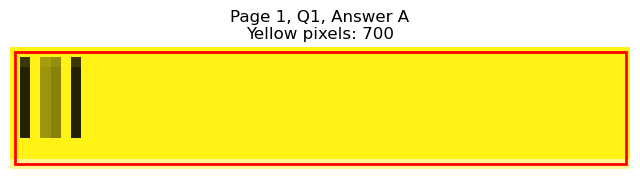

Page 1, Q1 - B: Detected box: x0=56.6, y0=154.3, x1=65.2, y1=165.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 50
Page 1, Q1, B: Yellow percentage: 0.0%


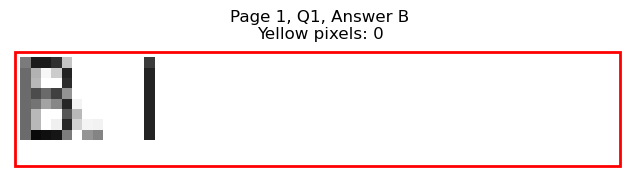

Page 1, Q1 - C: Detected box: x0=315.4, y0=141.7, x1=324.4, y1=152.7
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 70
Page 1, Q1, C: Yellow percentage: 0.0%


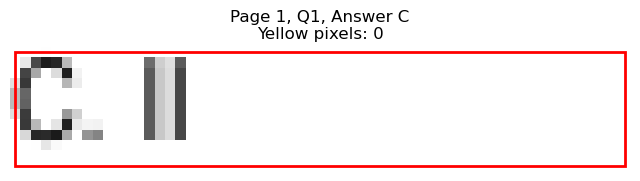

Page 1, Q1 - D: Detected box: x0=315.4, y0=154.3, x1=324.4, y1=165.3
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 71
Page 1, Q1, D: Yellow percentage: 0.0%


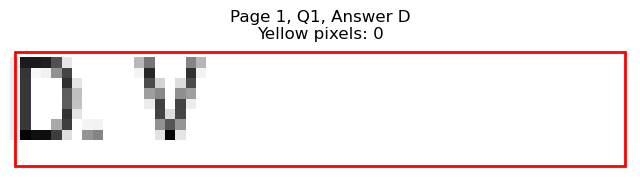


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=91.3, y1=203.1
Page 1, Q2, A: Yellow pixels: 74
Page 1, Q2, A: Total non-white pixels: 265
Page 1, Q2, A: Yellow percentage: 27.9%


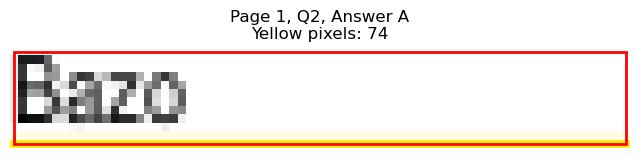

Page 1, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=130.4, y1=215.7
Page 1, Q2, B: Yellow pixels: 1126
Page 1, Q2, B: Total non-white pixels: 1356
Page 1, Q2, B: Yellow percentage: 83.0%


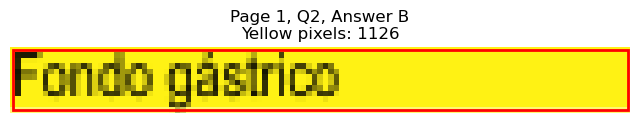

Page 1, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=353.6, y1=203.1
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 127
Page 1, Q2, C: Yellow percentage: 0.0%


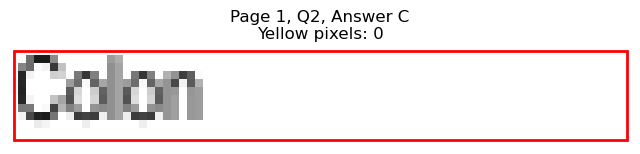

Page 1, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=360.1, y1=215.7
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 149
Page 1, Q2, D: Yellow percentage: 0.0%


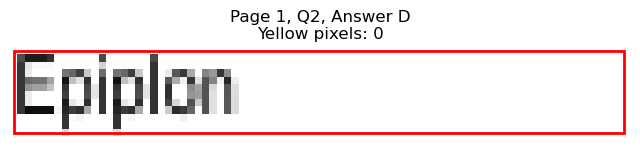


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=138.0, y1=278.8
Page 1, Q3, A: Yellow pixels: 1207
Page 1, Q3, A: Total non-white pixels: 1440
Page 1, Q3, A: Yellow percentage: 83.8%


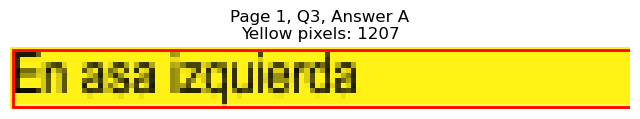

Page 1, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=134.0, y1=291.6
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 313
Page 1, Q3, B: Yellow percentage: 0.0%


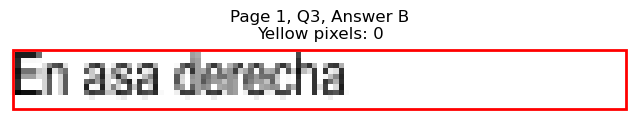

Page 1, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=419.8, y1=278.8
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 443
Page 1, Q3, C: Yellow percentage: 0.0%


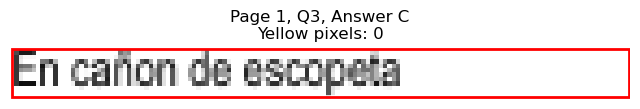

Page 1, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=431.8, y1=291.6
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 542
Page 1, Q3, D: Yellow percentage: 0.0%


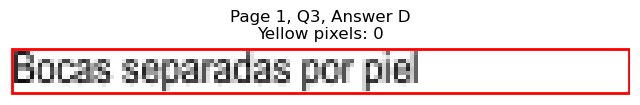


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=116.4, y1=354.7
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 259
Page 1, Q4, A: Yellow percentage: 0.0%


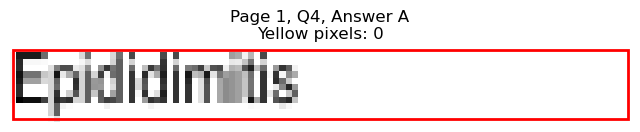

Page 1, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=101.9, y1=367.3
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 170
Page 1, Q4, B: Yellow percentage: 0.0%


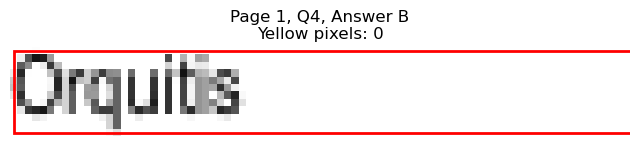

Page 1, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=372.1, y1=354.7
Page 1, Q4, C: Yellow pixels: 96
Page 1, Q4, C: Total non-white pixels: 315
Page 1, Q4, C: Yellow percentage: 30.5%


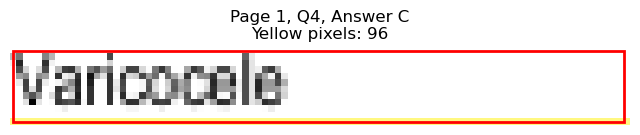

Page 1, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=398.6, y1=367.3
Page 1, Q4, D: Yellow pixels: 1079
Page 1, Q4, D: Total non-white pixels: 1464
Page 1, Q4, D: Yellow percentage: 73.7%


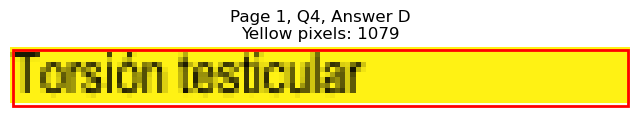


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=126.5, y1=417.7
Page 1, Q5, A: Yellow pixels: 1073
Page 1, Q5, A: Total non-white pixels: 1308
Page 1, Q5, A: Yellow percentage: 82.0%


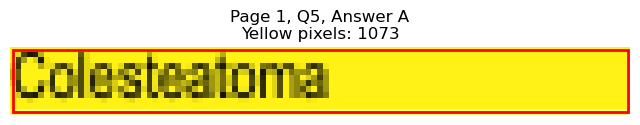

Page 1, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=123.0, y1=430.4
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 278
Page 1, Q5, B: Yellow percentage: 0.0%


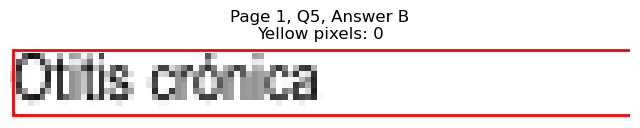

Page 1, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=378.1, y1=417.7
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 277
Page 1, Q5, C: Yellow percentage: 0.0%


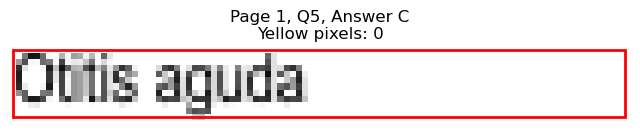

Page 1, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=402.2, y1=430.4
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 374
Page 1, Q5, D: Yellow percentage: 0.0%


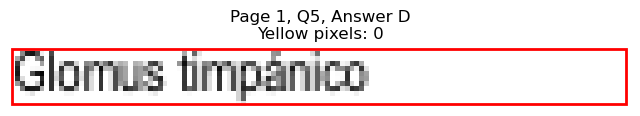


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=495.1, x1=174.6, y1=506.1
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 474
Page 1, Q6, A: Yellow percentage: 0.0%


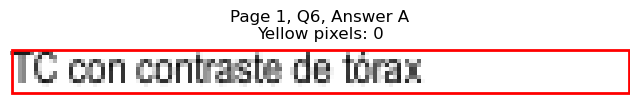

Page 1, Q6 - B: Detected box: x0=68.3, y0=507.7, x1=126.5, y1=518.7
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 302
Page 1, Q6, B: Yellow percentage: 0.0%


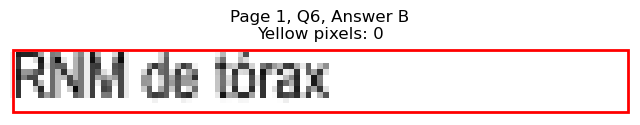

Page 1, Q6 - C: Detected box: x0=327.5, y0=495.1, x1=414.2, y1=506.1
Page 1, Q6, C: Yellow pixels: 138
Page 1, Q6, C: Total non-white pixels: 699
Page 1, Q6, C: Yellow percentage: 19.7%


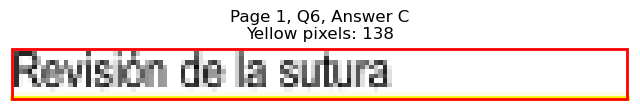

Page 1, Q6 - D: Detected box: x0=327.5, y0=507.7, x1=431.3, y1=518.7
Page 1, Q6, D: Yellow pixels: 1462
Page 1, Q6, D: Total non-white pixels: 1860
Page 1, Q6, D: Yellow percentage: 78.6%


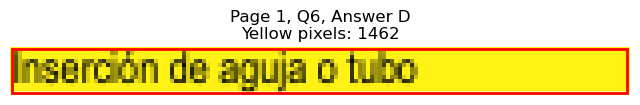


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=558.2, x1=172.6, y1=569.2
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 481
Page 1, Q7, A: Yellow percentage: 0.0%


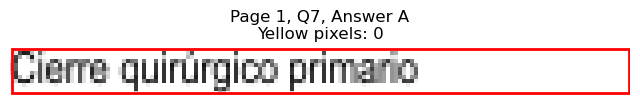

Page 1, Q7 - B: Detected box: x0=68.3, y0=570.8, x1=244.3, y1=581.8
Page 1, Q7, B: Yellow pixels: 2
Page 1, Q7, B: Total non-white pixels: 1103
Page 1, Q7, B: Yellow percentage: 0.2%


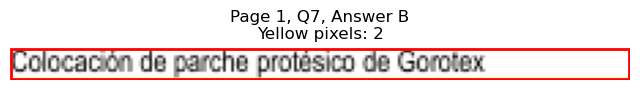

Page 1, Q7 - C: Detected box: x0=68.8, y0=583.4, x1=314.5, y1=594.4
Page 1, Q7, C: Yellow pixels: 2335
Page 1, Q7, C: Total non-white pixels: 3564
Page 1, Q7, C: Yellow percentage: 65.5%


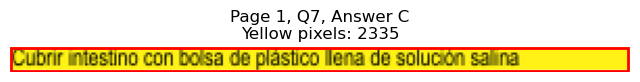

Page 1, Q7 - D: Detected box: x0=68.8, y0=596.0, x1=242.3, y1=607.0
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 863
Page 1, Q7, D: Yellow percentage: 0.0%


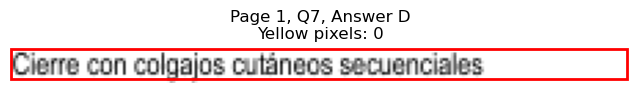


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=659.1, x1=87.4, y1=670.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 70
Page 1, Q8, A: Yellow percentage: 0.0%


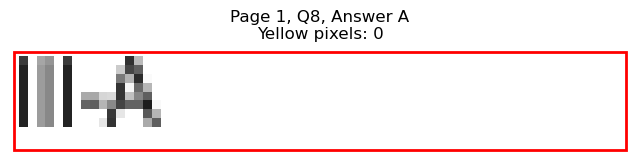

Page 1, Q8 - B: Detected box: x0=68.3, y0=671.7, x1=87.8, y1=682.8
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 72
Page 1, Q8, B: Yellow percentage: 0.0%


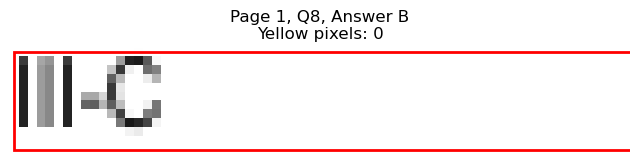

Page 1, Q8 - C: Detected box: x0=327.5, y0=659.1, x1=346.6, y1=670.2
Page 1, Q8, C: Yellow pixels: 689
Page 1, Q8, C: Total non-white pixels: 770
Page 1, Q8, C: Yellow percentage: 89.5%


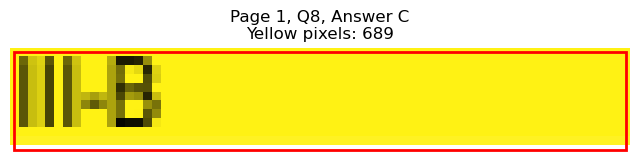

Page 1, Q8 - D: Detected box: x0=327.5, y0=671.7, x1=338.5, y1=682.8
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 43
Page 1, Q8, D: Yellow percentage: 0.0%


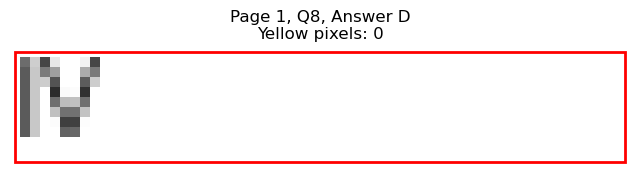


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=747.4, x1=162.6, y1=758.5
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 474
Page 1, Q9, A: Yellow percentage: 0.0%


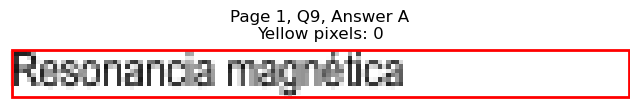

Page 1, Q9 - B: Detected box: x0=68.3, y0=760.2, x1=116.9, y1=771.2
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 237
Page 1, Q9, B: Yellow percentage: 0.0%


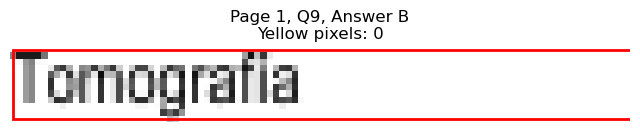

Page 1, Q9 - C: Detected box: x0=327.5, y0=747.4, x1=401.2, y1=758.5
Page 1, Q9, C: Yellow pixels: 1084
Page 1, Q9, C: Total non-white pixels: 1500
Page 1, Q9, C: Yellow percentage: 72.3%


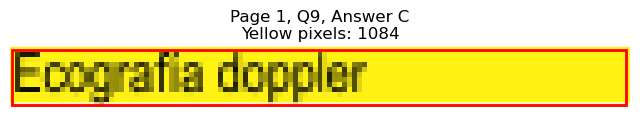

Page 1, Q9 - D: Detected box: x0=327.5, y0=760.2, x1=375.6, y1=771.2
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 265
Page 1, Q9, D: Yellow percentage: 0.0%


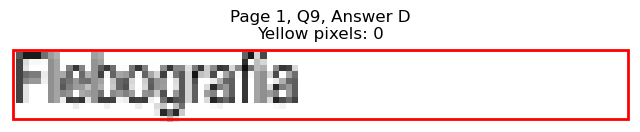


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=136.4, y1=127.4
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 353
Page 2, Q1, A: Yellow percentage: 0.0%


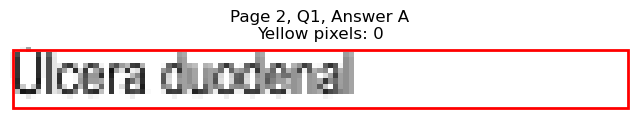

Page 2, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=149.5, y1=140.0
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 377
Page 2, Q1, B: Yellow percentage: 0.0%


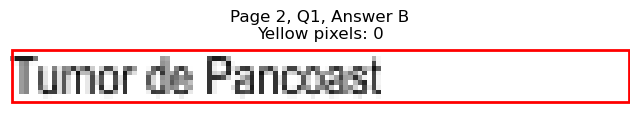

Page 2, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=378.1, y1=127.4
Page 2, Q1, C: Yellow pixels: 902
Page 2, Q1, C: Total non-white pixels: 1224
Page 2, Q1, C: Yellow percentage: 73.7%


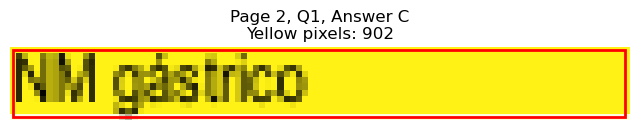

Page 2, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=396.2, y1=140.0
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 332
Page 2, Q1, D: Yellow percentage: 0.0%


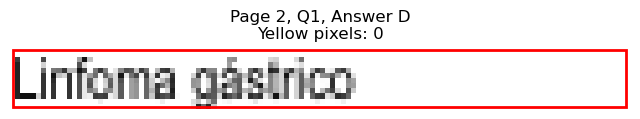


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=56.6, y0=166.9, x1=65.2, y1=177.9
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 44
Page 2, Q2, A: Yellow percentage: 0.0%


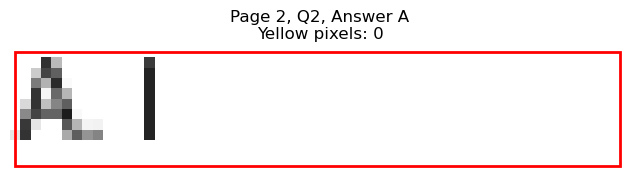

Page 2, Q2 - B: Detected box: x0=56.6, y0=179.5, x1=65.2, y1=190.5
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 66
Page 2, Q2, B: Yellow percentage: 0.0%


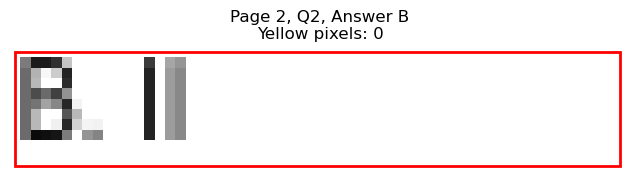

Page 2, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=338.5, y1=177.9
Page 2, Q2, C: Yellow pixels: 704
Page 2, Q2, C: Total non-white pixels: 744
Page 2, Q2, C: Yellow percentage: 94.6%


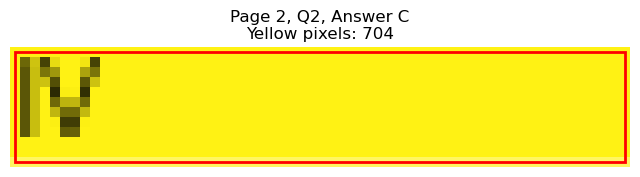

Page 2, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=337.6, y1=190.5
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 48
Page 2, Q2, D: Yellow percentage: 0.0%


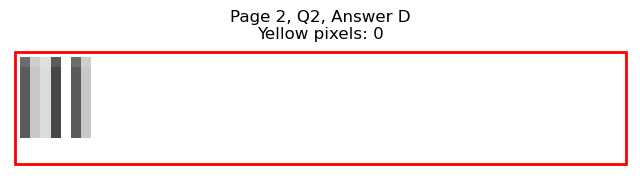


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=189.1, y1=266.2
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 623
Page 2, Q3, A: Yellow percentage: 0.0%


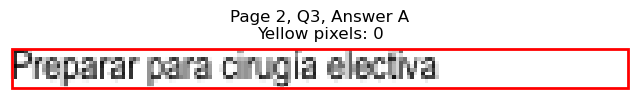

Page 2, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=205.7, y1=278.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 690
Page 2, Q3, B: Yellow percentage: 0.0%


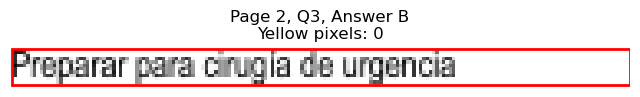

Page 2, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=530.0, y1=266.2
Page 2, Q3, C: Yellow pixels: 1604
Page 2, Q3, C: Total non-white pixels: 2349
Page 2, Q3, C: Yellow percentage: 68.3%


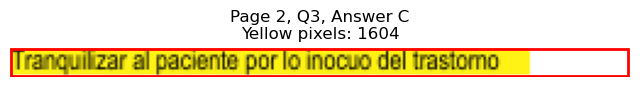

Page 2, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=511.6, y1=278.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 951
Page 2, Q3, D: Yellow percentage: 0.0%


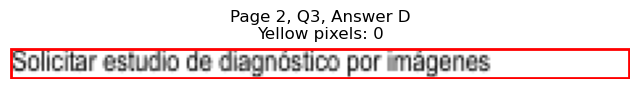


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=56.6, y0=330.9, x1=65.2, y1=342.0
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 60
Page 2, Q4, A: Yellow percentage: 0.0%


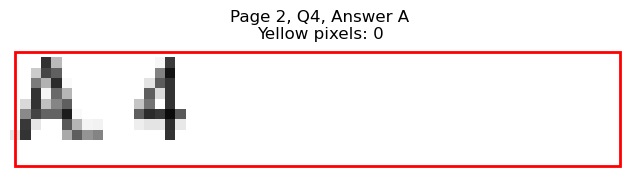

Page 2, Q4 - B: Detected box: x0=56.6, y0=343.6, x1=65.2, y1=354.7
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 73
Page 2, Q4, B: Yellow percentage: 0.0%


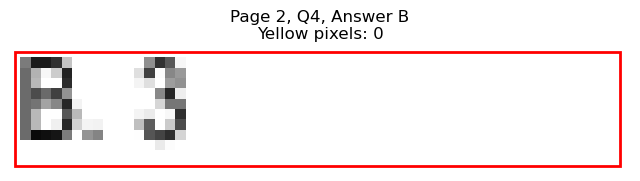

Page 2, Q4 - C: Detected box: x0=315.4, y0=330.9, x1=324.4, y1=342.0
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 130
Page 2, Q4, C: Yellow percentage: 0.0%


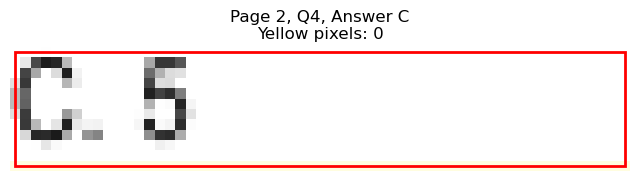

Page 2, Q4 - D: Detected box: x0=315.4, y0=343.6, x1=324.4, y1=354.7
Page 2, Q4, D: Yellow pixels: 675
Page 2, Q4, D: Total non-white pixels: 720
Page 2, Q4, D: Yellow percentage: 93.8%


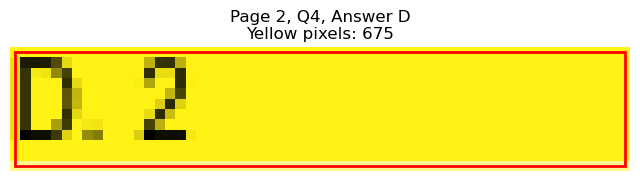


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=162.6, y1=417.7
Page 2, Q5, A: Yellow pixels: 1365
Page 2, Q5, A: Total non-white pixels: 1740
Page 2, Q5, A: Yellow percentage: 78.4%


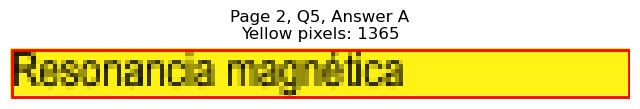

Page 2, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=183.6, y1=430.4
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 533
Page 2, Q5, B: Yellow percentage: 0.0%


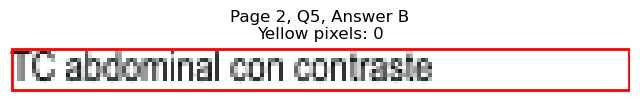

Page 2, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=421.8, y1=417.7
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 501
Page 2, Q5, C: Yellow percentage: 0.0%


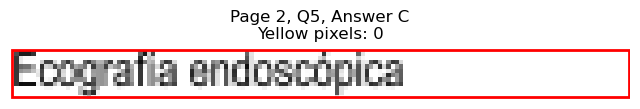

Page 2, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=439.8, y1=430.4
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 573
Page 2, Q5, D: Yellow percentage: 0.0%


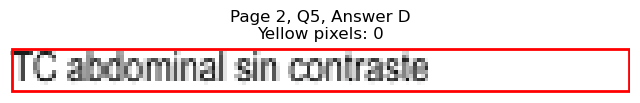


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=102.4, y1=493.5
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 184
Page 2, Q6, A: Yellow percentage: 0.0%


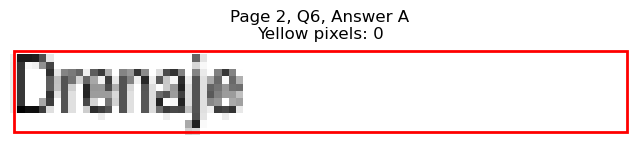

Page 2, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=124.0, y1=506.1
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 299
Page 2, Q6, B: Yellow percentage: 0.0%


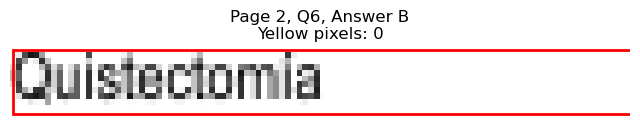

Page 2, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=419.3, y1=493.5
Page 2, Q6, C: Yellow pixels: 143
Page 2, Q6, C: Total non-white pixels: 602
Page 2, Q6, C: Yellow percentage: 23.8%


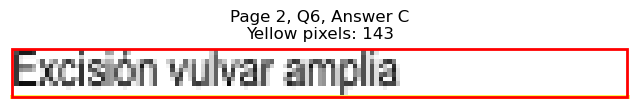

Page 2, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=397.2, y1=506.1
Page 2, Q6, D: Yellow pixels: 1056
Page 2, Q6, D: Total non-white pixels: 1333
Page 2, Q6, D: Yellow percentage: 79.2%


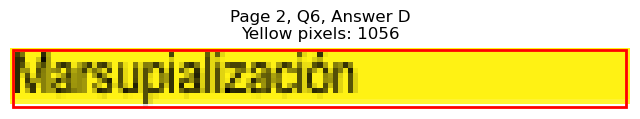


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=170.6, y1=556.5
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 512
Page 2, Q7, A: Yellow percentage: 0.0%


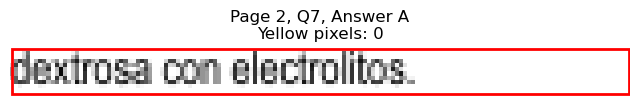

Page 2, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=120.5, y1=569.2
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 263
Page 2, Q7, B: Yellow percentage: 0.0%


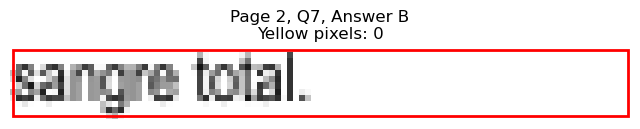

Page 2, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=467.4, y1=556.5
Page 2, Q7, C: Yellow pixels: 1543
Page 2, Q7, C: Total non-white pixels: 2292
Page 2, Q7, C: Yellow percentage: 67.3%


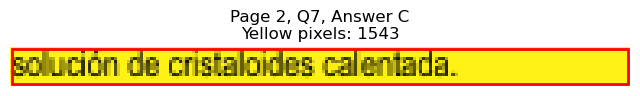

Page 2, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=388.7, y1=569.2
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 282
Page 2, Q7, D: Yellow percentage: 0.0%


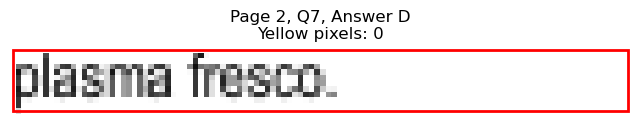


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=202.2, y1=619.6
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 672
Page 2, Q8, A: Yellow percentage: 0.0%


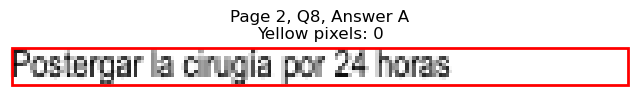

Page 2, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=241.2, y1=632.4
Page 2, Q8, B: Yellow pixels: 224
Page 2, Q8, B: Total non-white pixels: 1076
Page 2, Q8, B: Yellow percentage: 20.8%


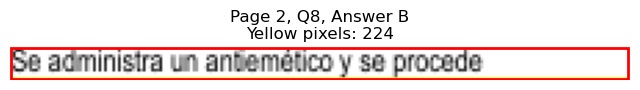

Page 2, Q8 - C: Detected box: x0=68.8, y0=633.9, x1=197.6, y1=645.0
Page 2, Q8, C: Yellow pixels: 1680
Page 2, Q8, C: Total non-white pixels: 2160
Page 2, Q8, C: Yellow percentage: 77.8%


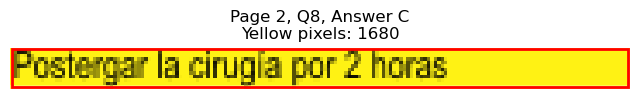

Page 2, Q8 - D: Detected box: x0=68.8, y0=646.5, x1=292.4, y1=657.6
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 1110
Page 2, Q8, D: Yellow percentage: 0.0%


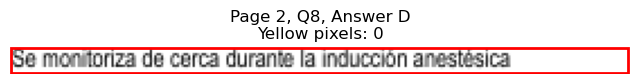


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=722.2, x1=187.8, y1=733.3
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 613
Page 2, Q9, A: Yellow percentage: 0.0%


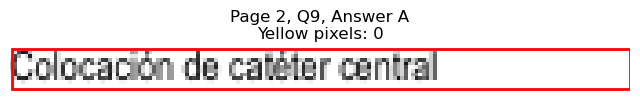

Page 2, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=170.2, y1=745.9
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 540
Page 2, Q9, B: Yellow percentage: 0.0%


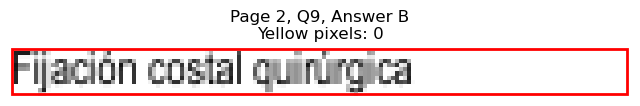

Page 2, Q9 - C: Detected box: x0=327.5, y0=722.2, x1=419.8, y1=733.3
Page 2, Q9, C: Yellow pixels: 1199
Page 2, Q9, C: Total non-white pixels: 1716
Page 2, Q9, C: Yellow percentage: 69.9%


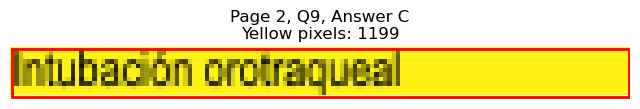

Page 2, Q9 - D: Detected box: x0=327.5, y0=734.8, x1=421.8, y1=745.9
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 474
Page 2, Q9, D: Yellow percentage: 0.0%


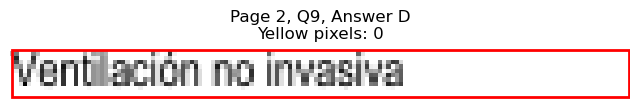


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=257.5, y1=102.2
Page 3, Q1, A: Yellow pixels: 240
Page 3, Q1, A: Total non-white pixels: 1410
Page 3, Q1, A: Yellow percentage: 17.0%


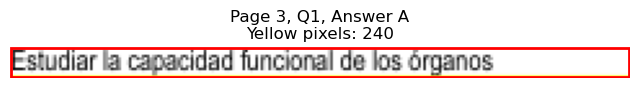

Page 3, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=417.8, y1=114.8
Page 3, Q1, B: Yellow pixels: 3442
Page 3, Q1, B: Total non-white pixels: 4800
Page 3, Q1, B: Yellow percentage: 71.7%


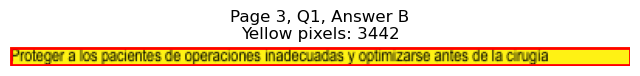

Page 3, Q1 - C: Detected box: x0=68.8, y0=116.4, x1=273.8, y1=127.4
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 1036
Page 3, Q1, C: Yellow percentage: 0.0%


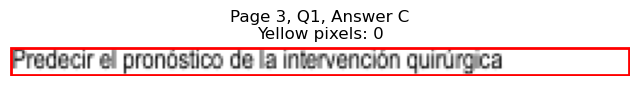

Page 3, Q1 - D: Detected box: x0=68.8, y0=129.0, x1=266.9, y1=140.0
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 1000
Page 3, Q1, D: Yellow percentage: 0.0%


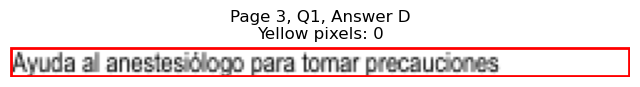


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=250.3, y1=177.9
Page 3, Q2, A: Yellow pixels: 2072
Page 3, Q2, A: Total non-white pixels: 2796
Page 3, Q2, A: Yellow percentage: 74.1%


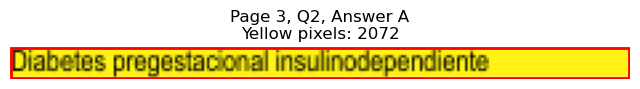

Page 3, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=313.0, y1=190.5
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 1167
Page 3, Q2, B: Yellow percentage: 0.0%


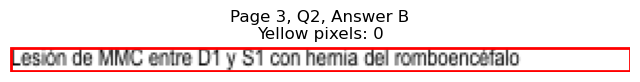

Page 3, Q2 - C: Detected box: x0=68.8, y0=192.1, x1=367.2, y1=203.1
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 1461
Page 3, Q2, C: Yellow percentage: 0.0%


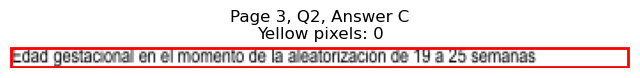

Page 3, Q2 - D: Detected box: x0=68.8, y0=204.7, x1=137.4, y1=215.7
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 335
Page 3, Q2, D: Yellow percentage: 0.0%


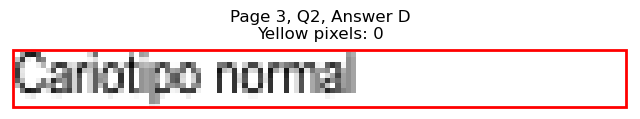


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=175.1, y1=253.6
Page 3, Q3, A: Yellow pixels: 158
Page 3, Q3, A: Total non-white pixels: 687
Page 3, Q3, A: Yellow percentage: 23.0%


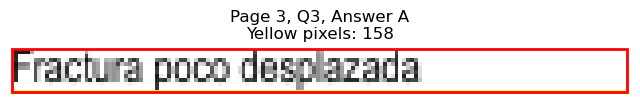

Page 3, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=258.4, y1=266.2
Page 3, Q3, B: Yellow pixels: 1629
Page 3, Q3, B: Total non-white pixels: 2360
Page 3, Q3, B: Yellow percentage: 69.0%


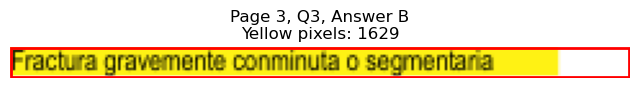

Page 3, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=421.8, y1=253.6
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 482
Page 3, Q3, C: Yellow percentage: 0.0%


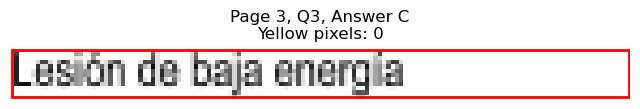

Page 3, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=485.5, y1=266.2
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 802
Page 3, Q3, D: Yellow percentage: 0.0%


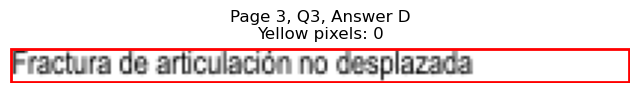


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=138.5, y1=304.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 349
Page 3, Q4, A: Yellow percentage: 0.0%


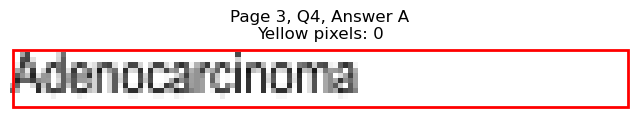

Page 3, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=102.8, y1=316.8
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 167
Page 3, Q4, B: Yellow percentage: 0.0%


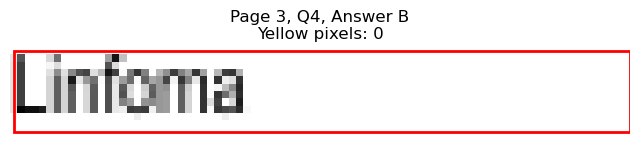

Page 3, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=425.8, y1=304.2
Page 3, Q4, C: Yellow pixels: 1265
Page 3, Q4, C: Total non-white pixels: 1641
Page 3, Q4, C: Yellow percentage: 77.1%


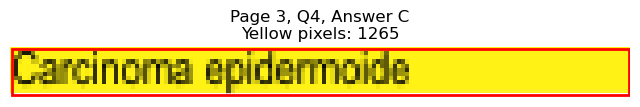

Page 3, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=384.6, y1=316.8
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 289
Page 3, Q4, D: Yellow percentage: 0.0%


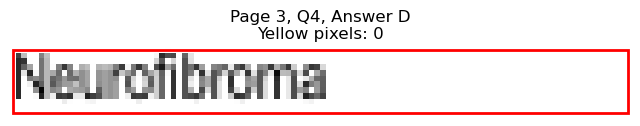


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=161.5, y1=379.9
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 437
Page 3, Q5, A: Yellow percentage: 0.0%


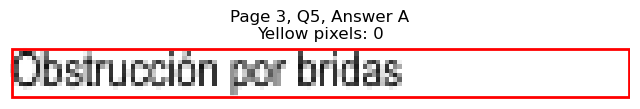

Page 3, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=152.5, y1=392.5
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 415
Page 3, Q5, B: Yellow percentage: 0.0%


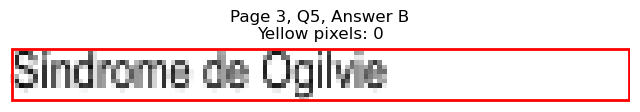

Page 3, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=414.4, y1=379.9
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 592
Page 3, Q5, C: Yellow percentage: 0.0%


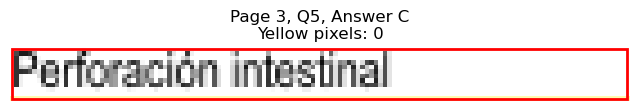

Page 3, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=383.6, y1=392.5
Page 3, Q5, D: Yellow pixels: 953
Page 3, Q5, D: Total non-white pixels: 1284
Page 3, Q5, D: Yellow percentage: 74.2%


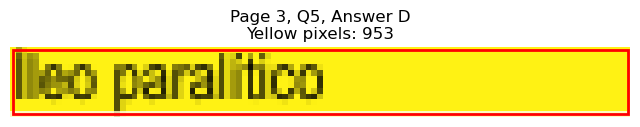


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=162.6, y1=430.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 440
Page 3, Q6, A: Yellow percentage: 0.0%


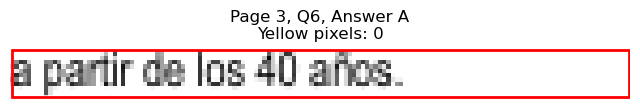

Page 3, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=228.8, y1=443.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 761
Page 3, Q6, B: Yellow percentage: 0.0%


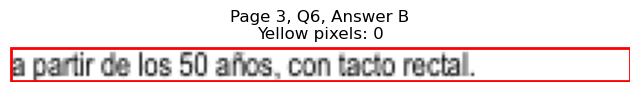

Page 3, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=536.0, y1=430.4
Page 3, Q6, C: Yellow pixels: 1558
Page 3, Q6, C: Total non-white pixels: 2556
Page 3, Q6, C: Yellow percentage: 61.0%


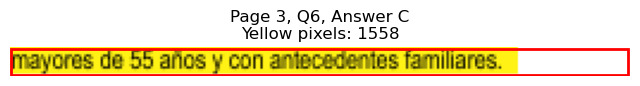

Page 3, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=506.5, y1=443.0
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 894
Page 3, Q6, D: Yellow percentage: 0.0%


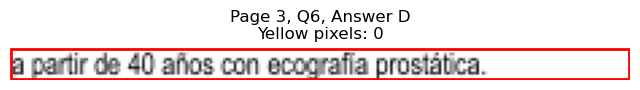


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=482.5, x1=303.0, y1=493.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 1177
Page 3, Q7, A: Yellow percentage: 0.0%


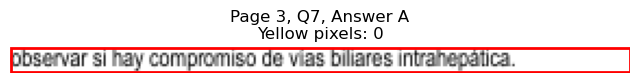

Page 3, Q7 - B: Detected box: x0=68.3, y0=495.1, x1=305.6, y1=506.1
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 1178
Page 3, Q7, B: Yellow percentage: 0.0%


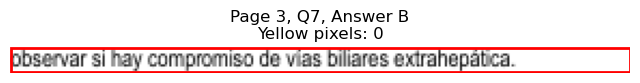

Page 3, Q7 - C: Detected box: x0=68.8, y0=507.7, x1=263.4, y1=518.7
Page 3, Q7, C: Yellow pixels: 246
Page 3, Q7, C: Total non-white pixels: 1175
Page 3, Q7, C: Yellow percentage: 20.9%


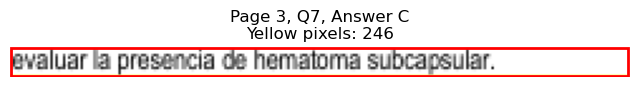

Page 3, Q7 - D: Detected box: x0=68.8, y0=520.3, x1=257.9, y1=531.3
Page 3, Q7, D: Yellow pixels: 1936
Page 3, Q7, D: Total non-white pixels: 2880
Page 3, Q7, D: Yellow percentage: 67.2%


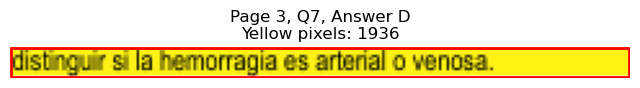


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=88.8, y1=569.2
Page 3, Q8, A: Yellow pixels: 700
Page 3, Q8, A: Total non-white pixels: 784
Page 3, Q8, A: Yellow percentage: 89.3%


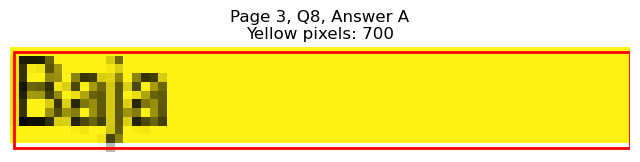

Page 3, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=86.4, y1=581.8
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 87
Page 3, Q8, B: Yellow percentage: 0.0%


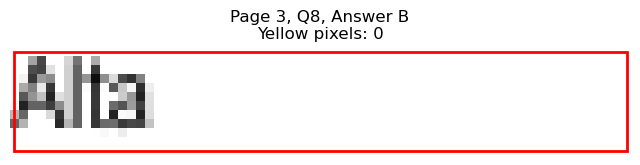

Page 3, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=372.6, y1=569.2
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 238
Page 3, Q8, C: Yellow percentage: 0.0%


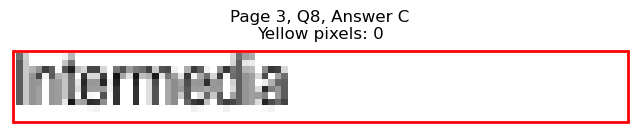

Page 3, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=366.6, y1=581.8
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 208
Page 3, Q8, D: Yellow percentage: 0.0%


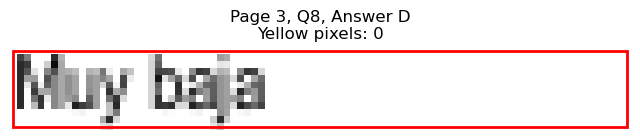


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=224.8, y1=619.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 744
Page 3, Q9, A: Yellow percentage: 0.0%


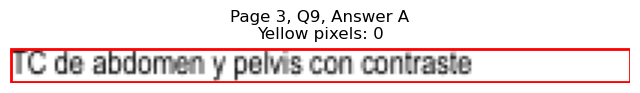

Page 3, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=157.6, y1=632.4
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 440
Page 3, Q9, B: Yellow percentage: 0.0%


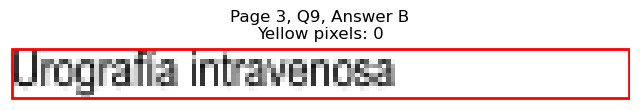

Page 3, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=481.0, y1=619.6
Page 3, Q9, C: Yellow pixels: 1903
Page 3, Q9, C: Total non-white pixels: 2448
Page 3, Q9, C: Yellow percentage: 77.7%


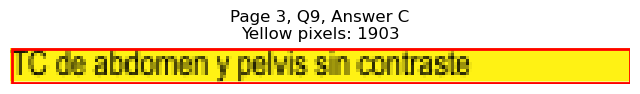

Page 3, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=405.2, y1=632.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 435
Page 3, Q9, D: Yellow percentage: 0.0%


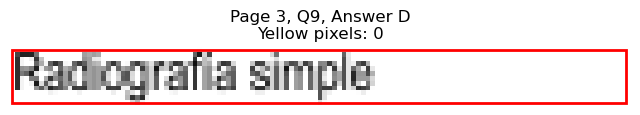


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=95.4, y1=682.8
Page 3, Q10, A: Yellow pixels: 78
Page 3, Q10, A: Total non-white pixels: 175
Page 3, Q10, A: Yellow percentage: 44.6%


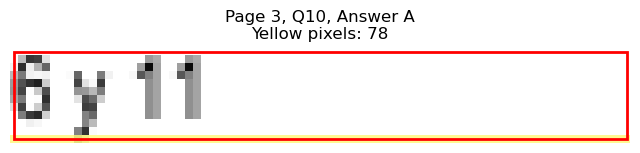

Page 3, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=100.4, y1=695.4
Page 3, Q10, B: Yellow pixels: 801
Page 3, Q10, B: Total non-white pixels: 996
Page 3, Q10, B: Yellow percentage: 80.4%


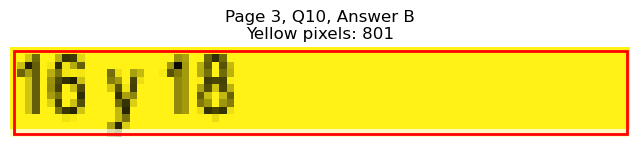

Page 3, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=359.6, y1=682.8
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 143
Page 3, Q10, C: Yellow percentage: 0.0%


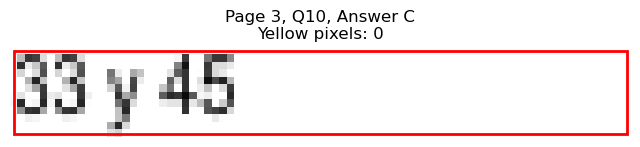

Page 3, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=354.6, y1=695.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 116
Page 3, Q10, D: Yellow percentage: 0.0%


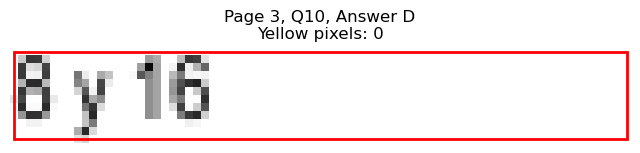


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=747.4, x1=193.7, y1=758.5
Page 3, Q11, A: Yellow pixels: 0
Page 3, Q11, A: Total non-white pixels: 637
Page 3, Q11, A: Yellow percentage: 0.0%


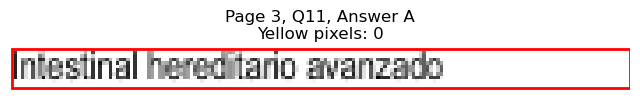

Page 3, Q11 - B: Detected box: x0=68.3, y0=760.2, x1=199.7, y1=771.2
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 653
Page 3, Q11, B: Yellow percentage: 0.0%


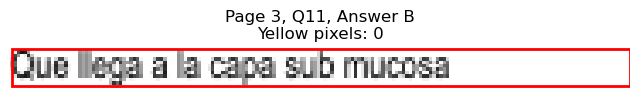

Page 3, Q11 - C: Detected box: x0=327.5, y0=747.4, x1=508.4, y1=758.5
Page 3, Q11, C: Yellow pixels: 213
Page 3, Q11, C: Total non-white pixels: 1170
Page 3, Q11, C: Yellow percentage: 18.2%


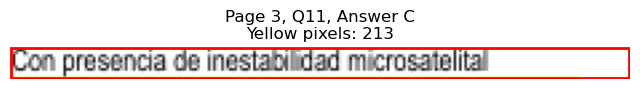

Page 3, Q11 - D: Detected box: x0=327.5, y0=760.2, x1=442.3, y1=771.2
Page 3, Q11, D: Yellow pixels: 1399
Page 3, Q11, D: Total non-white pixels: 1826
Page 3, Q11, D: Yellow percentage: 76.6%


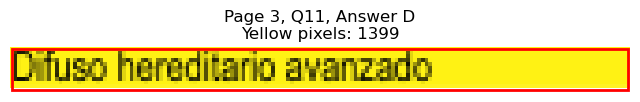


Page 3, Q11 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=167.6, y1=127.4
Page 4, Q1, A: Yellow pixels: 1247
Page 4, Q1, A: Total non-white pixels: 1800
Page 4, Q1, A: Yellow percentage: 69.3%


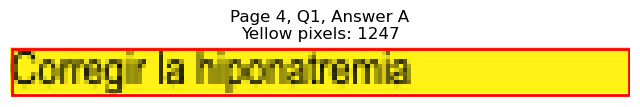

Page 4, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=144.6, y1=140.0
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 386
Page 4, Q1, B: Yellow percentage: 0.0%


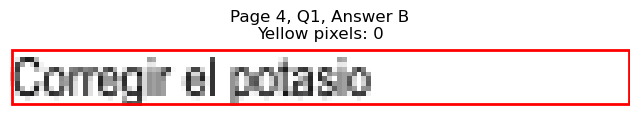

Page 4, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=375.7, y1=127.4
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 263
Page 4, Q1, C: Yellow percentage: 0.0%


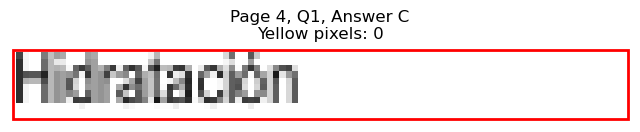

Page 4, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=422.9, y1=140.0
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 493
Page 4, Q1, D: Yellow percentage: 0.0%


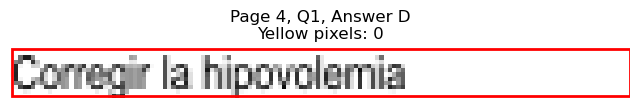


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=152.5, y1=203.1
Page 4, Q2, A: Yellow pixels: 1142
Page 4, Q2, A: Total non-white pixels: 1485
Page 4, Q2, A: Yellow percentage: 76.9%


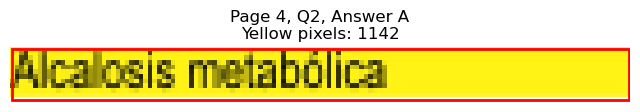

Page 4, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=130.9, y1=215.7
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 317
Page 4, Q2, B: Yellow percentage: 0.0%


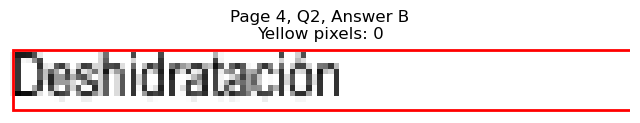

Page 4, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=420.2, y1=203.1
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 497
Page 4, Q2, C: Yellow percentage: 0.0%


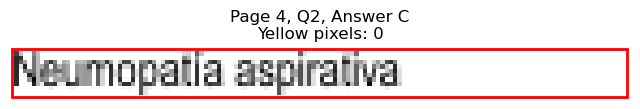

Page 4, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=394.7, y1=215.7
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 339
Page 4, Q2, D: Yellow percentage: 0.0%


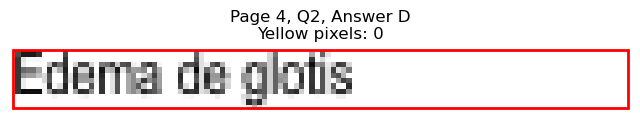


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=185.6, y1=253.6
Page 4, Q3, A: Yellow pixels: 168
Page 4, Q3, A: Total non-white pixels: 796
Page 4, Q3, A: Yellow percentage: 21.1%


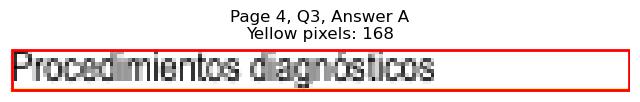

Page 4, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=170.0, y1=266.2
Page 4, Q3, B: Yellow pixels: 1284
Page 4, Q3, B: Total non-white pixels: 1686
Page 4, Q3, B: Yellow percentage: 76.2%


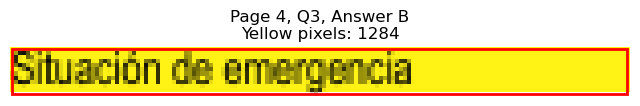

Page 4, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=475.4, y1=253.6
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 732
Page 4, Q3, C: Yellow percentage: 0.0%


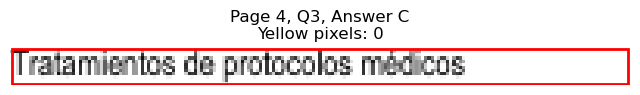

Page 4, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=414.2, y1=266.2
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 454
Page 4, Q3, D: Yellow percentage: 0.0%


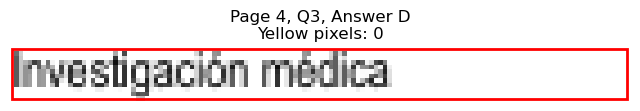


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=150.5, y1=316.8
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 398
Page 4, Q4, A: Yellow percentage: 0.0%


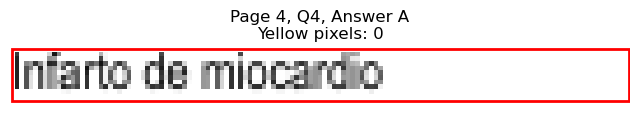

Page 4, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=171.6, y1=329.4
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 500
Page 4, Q4, B: Yellow percentage: 0.0%


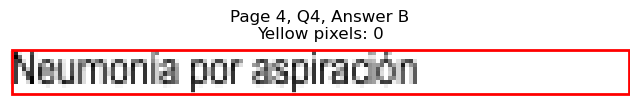

Page 4, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=427.8, y1=316.8
Page 4, Q4, C: Yellow pixels: 151
Page 4, Q4, C: Total non-white pixels: 660
Page 4, Q4, C: Yellow percentage: 22.9%


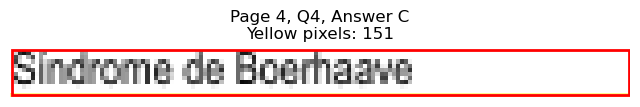

Page 4, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=417.2, y1=329.4
Page 4, Q4, D: Yellow pixels: 1197
Page 4, Q4, D: Total non-white pixels: 1692
Page 4, Q4, D: Yellow percentage: 70.7%


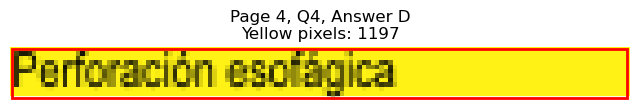


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=244.9, y1=367.3
Page 4, Q5, A: Yellow pixels: 1676
Page 4, Q5, A: Total non-white pixels: 2567
Page 4, Q5, A: Yellow percentage: 65.3%


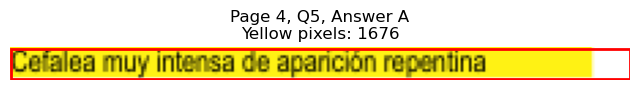

Page 4, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=241.3, y1=379.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 892
Page 4, Q5, B: Yellow percentage: 0.0%


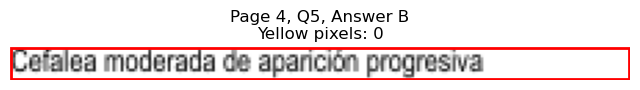

Page 4, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=445.8, y1=367.3
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 581
Page 4, Q5, C: Yellow percentage: 0.0%


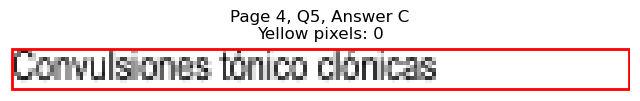

Page 4, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=472.4, y1=379.9
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 738
Page 4, Q5, D: Yellow percentage: 0.0%


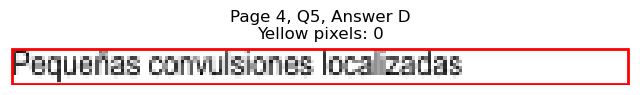


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=185.6, y1=455.6
Page 4, Q6, A: Yellow pixels: 1389
Page 4, Q6, A: Total non-white pixels: 2016
Page 4, Q6, A: Yellow percentage: 68.9%


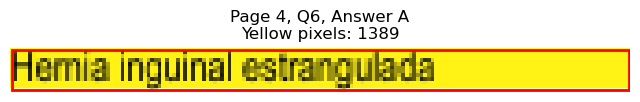

Page 4, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=174.1, y1=468.2
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 533
Page 4, Q6, B: Yellow percentage: 0.0%


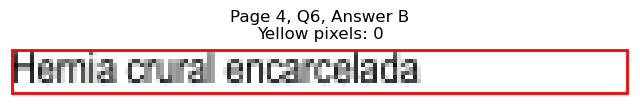

Page 4, Q6 - C: Detected box: x0=327.5, y0=444.6, x1=456.4, y1=455.6
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 705
Page 4, Q6, C: Yellow percentage: 0.0%


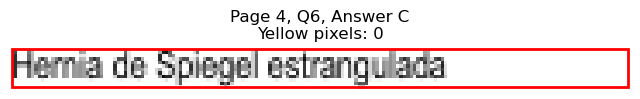

Page 4, Q6 - D: Detected box: x0=327.5, y0=457.2, x1=388.3, y1=468.2
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 310
Page 4, Q6, D: Yellow percentage: 0.0%


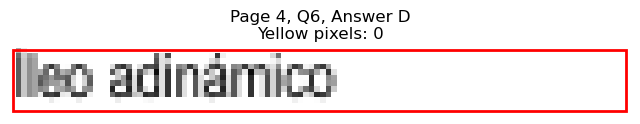


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=161.0, y1=506.1
Page 4, Q7, A: Yellow pixels: 144
Page 4, Q7, A: Total non-white pixels: 776
Page 4, Q7, A: Yellow percentage: 18.6%


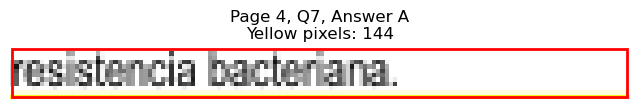

Page 4, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=113.9, y1=518.7
Page 4, Q7, B: Yellow pixels: 977
Page 4, Q7, B: Total non-white pixels: 1152
Page 4, Q7, B: Yellow percentage: 84.8%


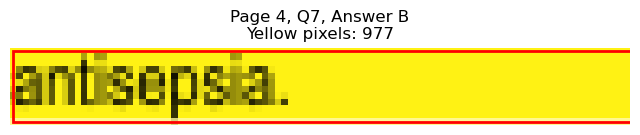

Page 4, Q7 - C: Detected box: x0=327.5, y0=495.1, x1=472.9, y1=506.1
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 738
Page 4, Q7, C: Yellow percentage: 0.0%


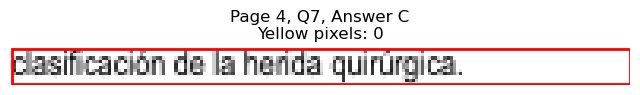

Page 4, Q7 - D: Detected box: x0=327.5, y0=507.7, x1=466.3, y1=518.7
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 727
Page 4, Q7, D: Yellow percentage: 0.0%


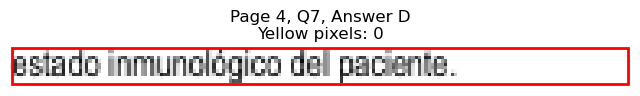


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=227.3, y1=569.2
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 820
Page 4, Q8, A: Yellow percentage: 0.0%


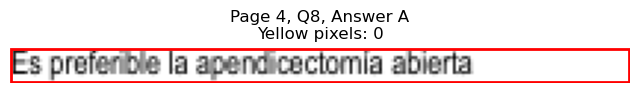

Page 4, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=264.4, y1=581.8
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 987
Page 4, Q8, B: Yellow percentage: 0.0%


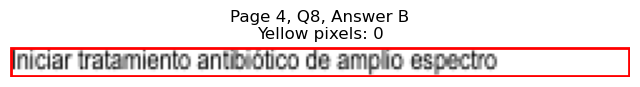

Page 4, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=483.5, y1=569.2
Page 4, Q8, C: Yellow pixels: 1669
Page 4, Q8, C: Total non-white pixels: 2279
Page 4, Q8, C: Yellow percentage: 73.2%


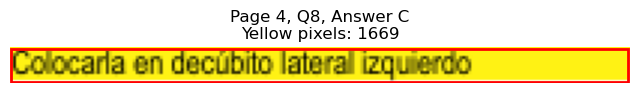

Page 4, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=429.8, y1=581.8
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 515
Page 4, Q8, D: Yellow percentage: 0.0%


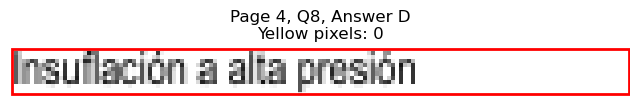


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=621.3, x1=250.4, y1=632.4
Page 4, Q9, A: Yellow pixels: 213
Page 4, Q9, A: Total non-white pixels: 1143
Page 4, Q9, A: Yellow percentage: 18.6%


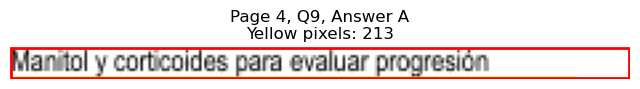

Page 4, Q9 - B: Detected box: x0=68.3, y0=633.9, x1=225.8, y1=645.0
Page 4, Q9, B: Yellow pixels: 1912
Page 4, Q9, B: Total non-white pixels: 2496
Page 4, Q9, B: Yellow percentage: 76.6%


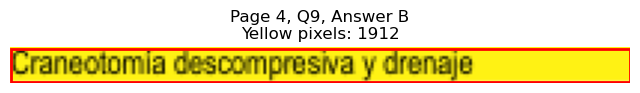

Page 4, Q9 - C: Detected box: x0=327.5, y0=621.3, x1=474.5, y1=632.4
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 734
Page 4, Q9, C: Yellow percentage: 0.0%


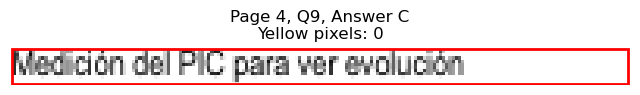

Page 4, Q9 - D: Detected box: x0=327.5, y0=633.9, x1=470.4, y1=645.0
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 749
Page 4, Q9, D: Yellow percentage: 0.0%


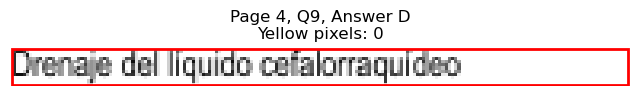


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=697.0, x1=141.0, y1=708.1
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 394
Page 4, Q10, A: Yellow percentage: 0.0%


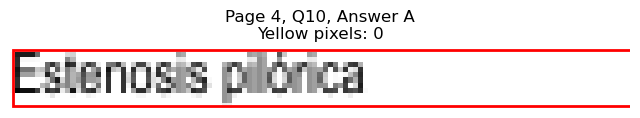

Page 4, Q10 - B: Detected box: x0=68.3, y0=709.6, x1=169.6, y1=720.7
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 512
Page 4, Q10, B: Yellow percentage: 0.0%


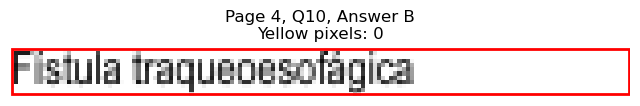

Page 4, Q10 - C: Detected box: x0=327.5, y0=697.0, x1=514.7, y1=708.1
Page 4, Q10, C: Yellow pixels: 1608
Page 4, Q10, C: Total non-white pixels: 2351
Page 4, Q10, C: Yellow percentage: 68.4%


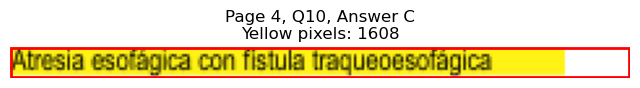

Page 4, Q10 - D: Detected box: x0=327.5, y0=709.6, x1=425.8, y1=720.7
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 478
Page 4, Q10, D: Yellow percentage: 0.0%


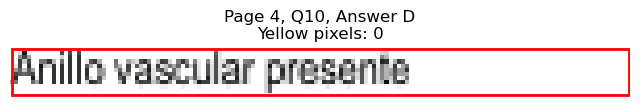


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=78.4, y1=114.8
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 32
Page 5, Q1, A: Yellow percentage: 0.0%


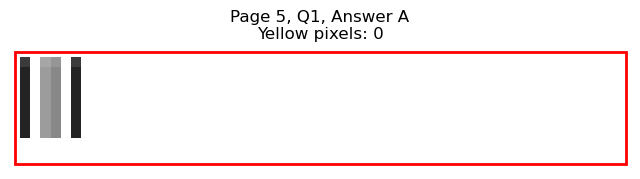

Page 5, Q1 - B: Detected box: x0=56.6, y0=116.4, x1=65.2, y1=127.4
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 50
Page 5, Q1, B: Yellow percentage: 0.0%


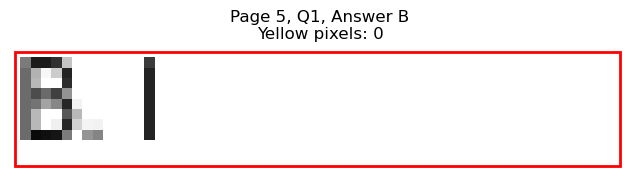

Page 5, Q1 - C: Detected box: x0=315.4, y0=444.6, x1=324.4, y1=455.6
Page 5, Q1, C: Yellow pixels: 611
Page 5, Q1, C: Total non-white pixels: 720
Page 5, Q1, C: Yellow percentage: 84.9%


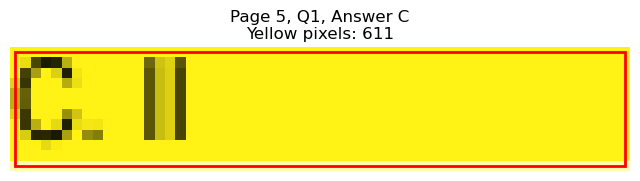

Page 5, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=338.5, y1=127.4
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 43
Page 5, Q1, D: Yellow percentage: 0.0%


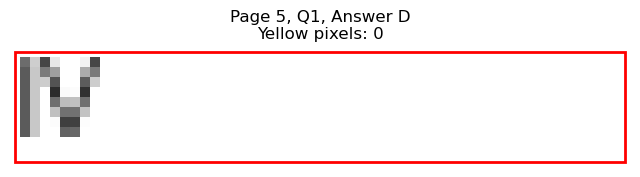


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=248.4, y1=190.5
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 868
Page 5, Q2, A: Yellow percentage: 0.0%


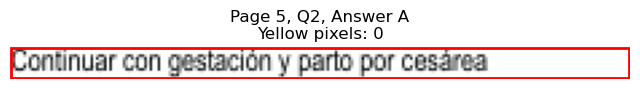

Page 5, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=277.4, y1=203.1
Page 5, Q2, B: Yellow pixels: 128
Page 5, Q2, B: Total non-white pixels: 1224
Page 5, Q2, B: Yellow percentage: 10.5%


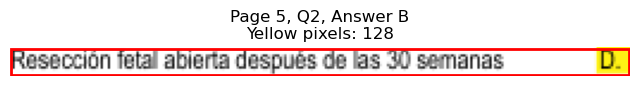

Page 5, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=437.9, y1=190.5
Page 5, Q2, C: Yellow pixels: 161
Page 5, Q2, C: Total non-white pixels: 749
Page 5, Q2, C: Yellow percentage: 21.5%


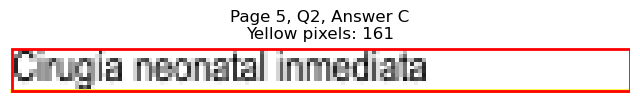

Page 5, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=524.8, y1=203.1
Page 5, Q2, D: Yellow pixels: 1592
Page 5, Q2, D: Total non-white pixels: 2343
Page 5, Q2, D: Yellow percentage: 67.9%


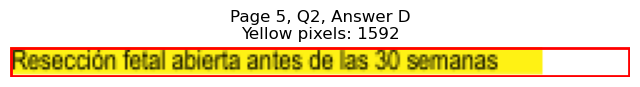


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=232.2, y1=241.0
Page 5, Q3, A: Yellow pixels: 213
Page 5, Q3, A: Total non-white pixels: 1227
Page 5, Q3, A: Yellow percentage: 17.4%


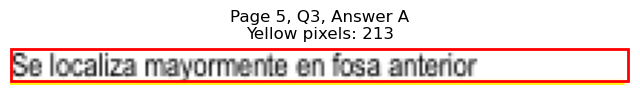

Page 5, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=164.5, y1=253.6
Page 5, Q3, B: Yellow pixels: 1280
Page 5, Q3, B: Total non-white pixels: 1764
Page 5, Q3, B: Yellow percentage: 72.6%


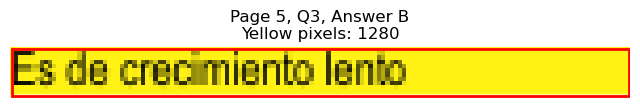

Page 5, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=429.2, y1=241.0
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 518
Page 5, Q3, C: Yellow percentage: 0.0%


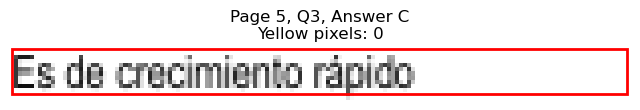

Page 5, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=472.9, y1=253.6
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 739
Page 5, Q3, D: Yellow percentage: 0.0%


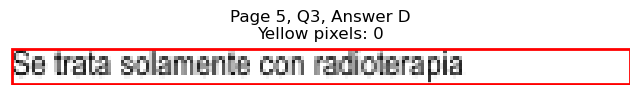


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=238.9, y1=291.6
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 896
Page 5, Q4, A: Yellow percentage: 0.0%


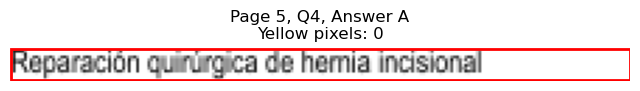

Page 5, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=167.5, y1=304.2
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 509
Page 5, Q4, B: Yellow percentage: 0.0%


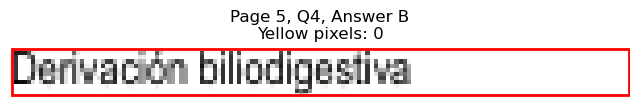

Page 5, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=440.9, y1=291.6
Page 5, Q4, C: Yellow pixels: 1376
Page 5, Q4, C: Total non-white pixels: 1968
Page 5, Q4, C: Yellow percentage: 69.9%


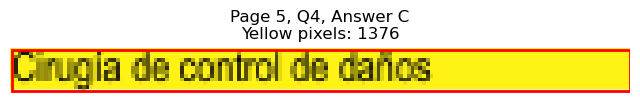

Page 5, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=433.8, y1=304.2
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 577
Page 5, Q4, D: Yellow percentage: 0.0%


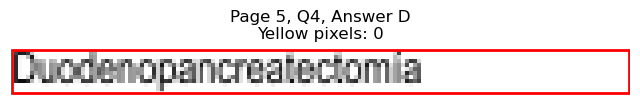


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=129.0, y1=367.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 311
Page 5, Q5, A: Yellow percentage: 0.0%


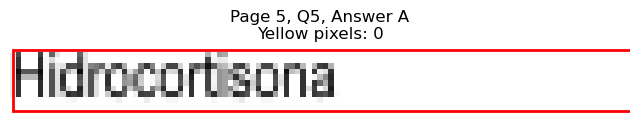

Page 5, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=116.9, y1=379.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 245
Page 5, Q5, B: Yellow percentage: 0.0%


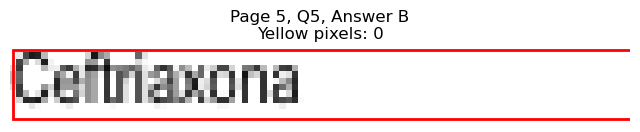

Page 5, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=371.2, y1=367.3
Page 5, Q5, C: Yellow pixels: 95
Page 5, Q5, C: Total non-white pixels: 324
Page 5, Q5, C: Yellow percentage: 29.3%


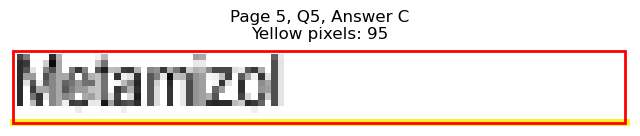

Page 5, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=360.1, y1=379.9
Page 5, Q5, D: Yellow pixels: 874
Page 5, Q5, D: Total non-white pixels: 1008
Page 5, Q5, D: Yellow percentage: 86.7%


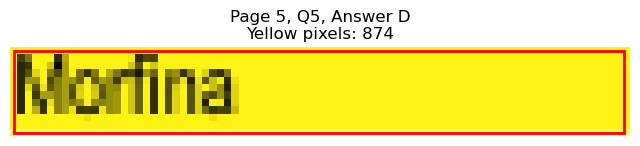


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=56.6, y0=444.6, x1=65.2, y1=455.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 44
Page 5, Q6, A: Yellow percentage: 0.0%


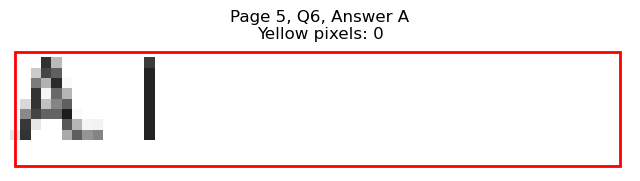

Page 5, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=78.4, y1=468.2
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 32
Page 5, Q6, B: Yellow percentage: 0.0%


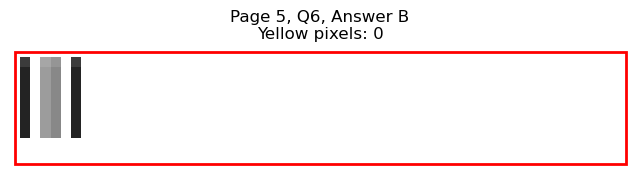

Page 5, Q6 - C: Detected box: x0=315.4, y0=444.6, x1=324.4, y1=455.6
Page 5, Q6, C: Yellow pixels: 611
Page 5, Q6, C: Total non-white pixels: 720
Page 5, Q6, C: Yellow percentage: 84.9%


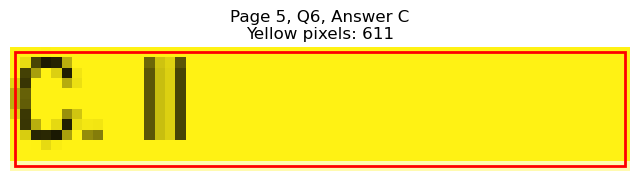

Page 5, Q6 - D: Detected box: x0=327.5, y0=116.4, x1=338.5, y1=127.4
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 43
Page 5, Q6, D: Yellow percentage: 0.0%


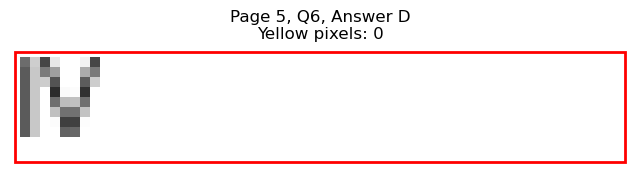


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=225.7, y1=506.1
Page 5, Q7, A: Yellow pixels: 208
Page 5, Q7, A: Total non-white pixels: 1198
Page 5, Q7, A: Yellow percentage: 17.4%


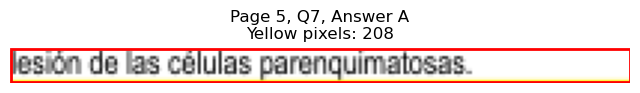

Page 5, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=258.8, y1=518.7
Page 5, Q7, B: Yellow pixels: 1821
Page 5, Q7, B: Total non-white pixels: 2568
Page 5, Q7, B: Yellow percentage: 70.9%


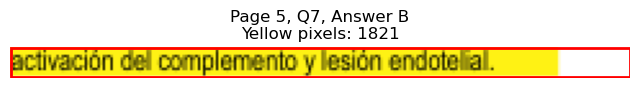

Page 5, Q7 - C: Detected box: x0=327.5, y0=495.1, x1=375.1, y1=506.1
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 253
Page 5, Q7, C: Yellow percentage: 0.0%


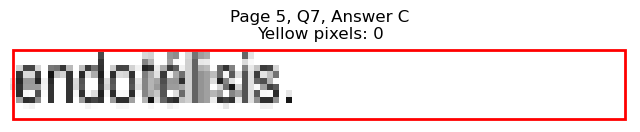

Page 5, Q7 - D: Detected box: x0=327.5, y0=507.7, x1=541.1, y1=518.7
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 1076
Page 5, Q7, D: Yellow percentage: 0.0%


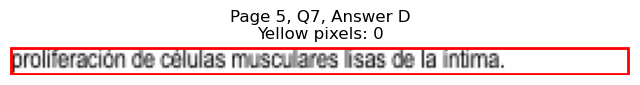


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=249.8, y1=569.2
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 957
Page 5, Q8, A: Yellow percentage: 0.0%


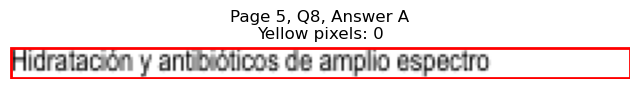

Page 5, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=173.8, y1=581.8
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 550
Page 5, Q8, B: Yellow percentage: 0.0%


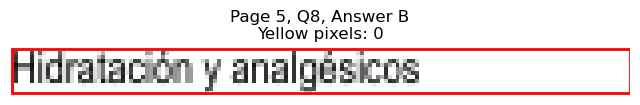

Page 5, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=491.4, y1=569.2
Page 5, Q8, C: Yellow pixels: 213
Page 5, Q8, C: Total non-white pixels: 1029
Page 5, Q8, C: Yellow percentage: 20.7%


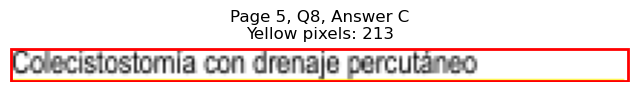

Page 5, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=514.7, y1=581.8
Page 5, Q8, D: Yellow pixels: 1830
Page 5, Q8, D: Total non-white pixels: 2556
Page 5, Q8, D: Yellow percentage: 71.6%


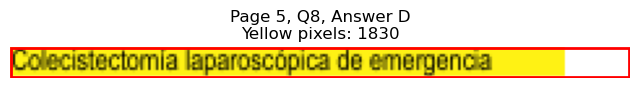


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=217.3, y1=619.6
Page 5, Q9, A: Yellow pixels: 1838
Page 5, Q9, A: Total non-white pixels: 2400
Page 5, Q9, A: Yellow percentage: 76.6%


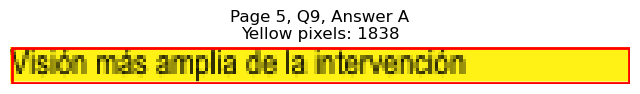

Page 5, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=258.4, y1=632.4
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 923
Page 5, Q9, B: Yellow percentage: 0.0%


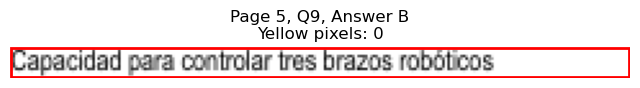

Page 5, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=526.6, y1=619.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 971
Page 5, Q9, C: Yellow percentage: 0.0%


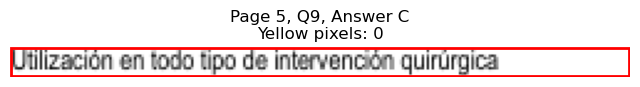

Page 5, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=440.8, y1=632.4
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 572
Page 5, Q9, D: Yellow percentage: 0.0%


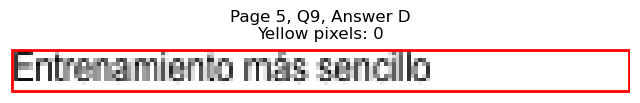


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=182.6, y1=695.4
Page 5, Q10, A: Yellow pixels: 1349
Page 5, Q10, A: Total non-white pixels: 1980
Page 5, Q10, A: Yellow percentage: 68.1%


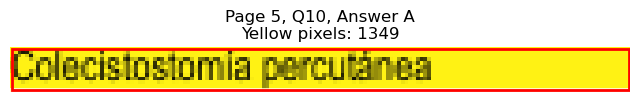

Page 5, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=193.2, y1=708.1
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 674
Page 5, Q10, B: Yellow percentage: 0.0%


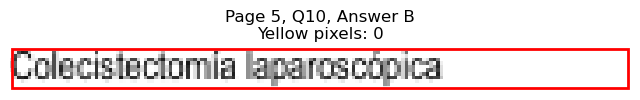

Page 5, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=514.1, y1=695.4
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 931
Page 5, Q10, C: Yellow percentage: 0.0%


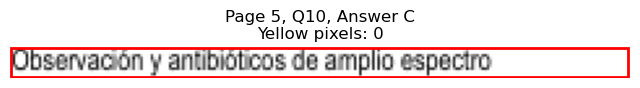

Page 5, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=423.2, y1=708.1
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 500
Page 5, Q10, D: Yellow percentage: 0.0%


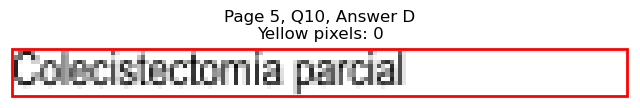


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=279.5, y1=127.4
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 1080
Page 6, Q1, A: Yellow percentage: 0.0%


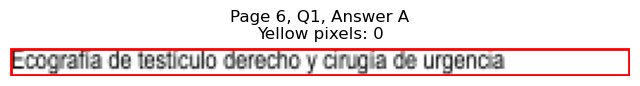

Page 6, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=340.7, y1=140.0
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 1700
Page 6, Q1, B: Yellow percentage: 0.0%


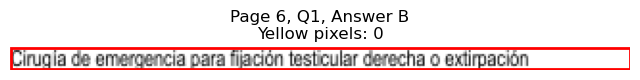

Page 6, Q1 - C: Detected box: x0=68.8, y0=141.7, x1=363.7, y1=152.7
Page 6, Q1, C: Yellow pixels: 2997
Page 6, Q1, C: Total non-white pixels: 4152
Page 6, Q1, C: Yellow percentage: 72.2%


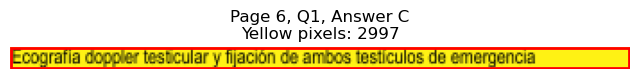

Page 6, Q1 - D: Detected box: x0=68.8, y0=154.3, x1=266.9, y1=165.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 996
Page 6, Q1, D: Yellow percentage: 0.0%


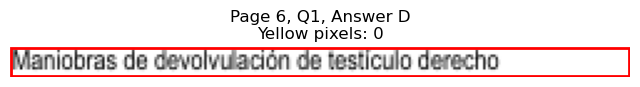


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=199.7, y1=203.1
Page 6, Q2, A: Yellow pixels: 182
Page 6, Q2, A: Total non-white pixels: 988
Page 6, Q2, A: Yellow percentage: 18.4%


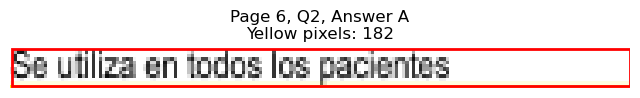

Page 6, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=243.4, y1=215.7
Page 6, Q2, B: Yellow pixels: 1882
Page 6, Q2, B: Total non-white pixels: 2568
Page 6, Q2, B: Yellow percentage: 73.3%


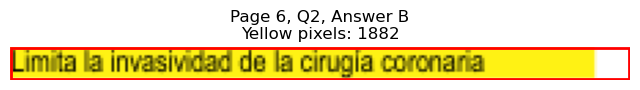

Page 6, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=461.9, y1=203.1
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 665
Page 6, Q2, C: Yellow percentage: 0.0%


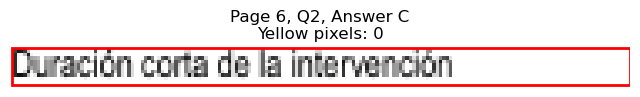

Page 6, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=475.4, y1=215.7
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 730
Page 6, Q2, D: Yellow percentage: 0.0%


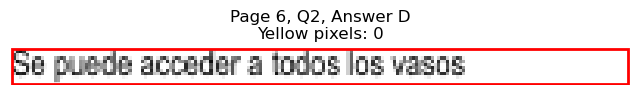


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=142.1, y1=291.6
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 376
Page 6, Q3, A: Yellow percentage: 0.0%


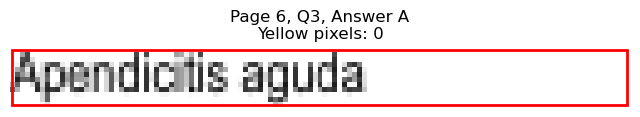

Page 6, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=159.6, y1=304.2
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 449
Page 6, Q3, B: Yellow percentage: 0.0%


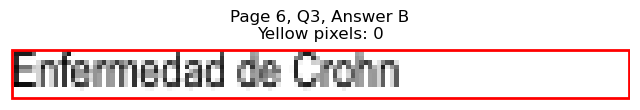

Page 6, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=397.3, y1=291.6
Page 6, Q3, C: Yellow pixels: 121
Page 6, Q3, C: Total non-white pixels: 481
Page 6, Q3, C: Yellow percentage: 25.2%


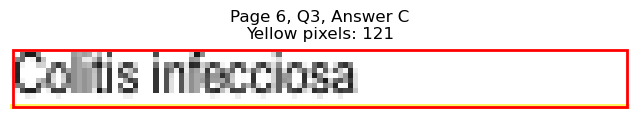

Page 6, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=405.8, y1=304.2
Page 6, Q3, D: Yellow pixels: 1102
Page 6, Q3, D: Total non-white pixels: 1422
Page 6, Q3, D: Yellow percentage: 77.5%


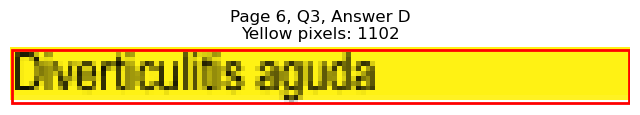


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=124.1, y1=354.7
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 250
Page 6, Q4, A: Yellow percentage: 0.0%


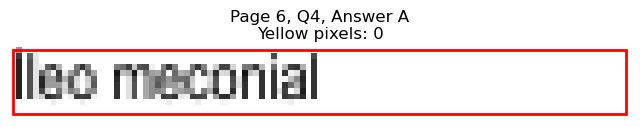

Page 6, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=138.5, y1=367.3
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 362
Page 6, Q4, B: Yellow percentage: 0.0%


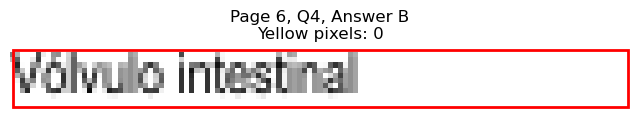

Page 6, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=417.4, y1=354.7
Page 6, Q4, C: Yellow pixels: 141
Page 6, Q4, C: Total non-white pixels: 612
Page 6, Q4, C: Yellow percentage: 23.0%


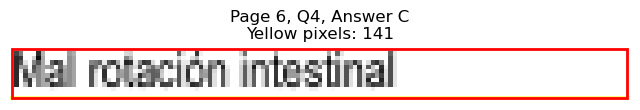

Page 6, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=397.7, y1=367.3
Page 6, Q4, D: Yellow pixels: 1045
Page 6, Q4, D: Total non-white pixels: 1452
Page 6, Q4, D: Yellow percentage: 72.0%


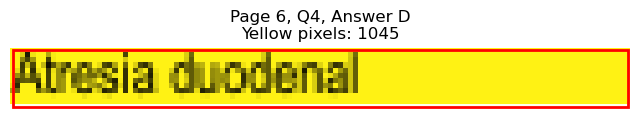


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=116.9, y1=405.1
Page 6, Q5, A: Yellow pixels: 931
Page 6, Q5, A: Total non-white pixels: 1089
Page 6, Q5, A: Yellow percentage: 85.5%


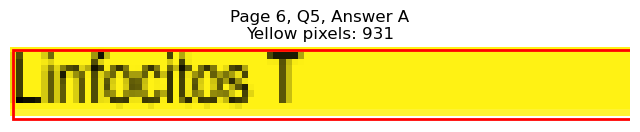

Page 6, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=171.6, y1=417.7
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 509
Page 6, Q5, B: Yellow percentage: 0.0%


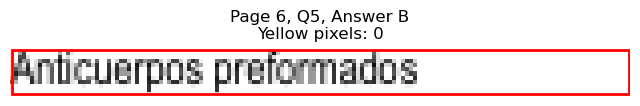

Page 6, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=376.7, y1=405.1
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 223
Page 6, Q5, C: Yellow percentage: 0.0%


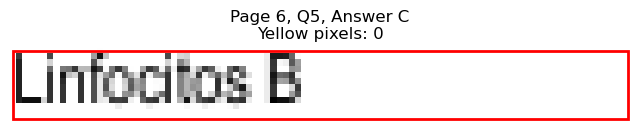

Page 6, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=400.2, y1=417.7
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 341
Page 6, Q5, D: Yellow percentage: 0.0%


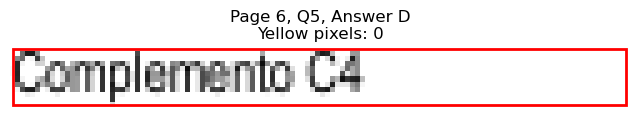


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=126.5, y1=468.2
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 338
Page 6, Q6, A: Yellow percentage: 0.0%


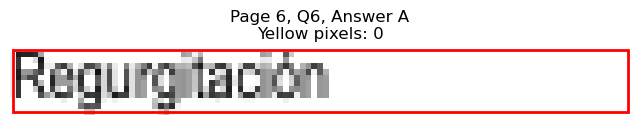

Page 6, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=136.4, y1=480.8
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 342
Page 6, Q6, B: Yellow percentage: 0.0%


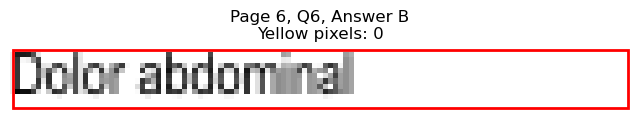

Page 6, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=357.1, y1=468.2
Page 6, Q6, C: Yellow pixels: 783
Page 6, Q6, C: Total non-white pixels: 891
Page 6, Q6, C: Yellow percentage: 87.9%


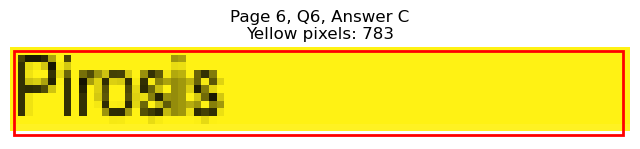

Page 6, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=360.6, y1=480.8
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 155
Page 6, Q6, D: Yellow percentage: 0.0%


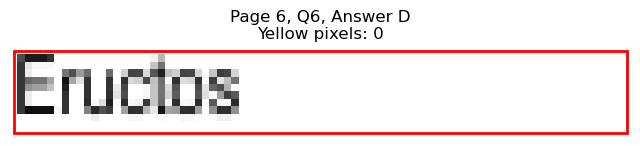


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=124.9, y1=518.7
Page 6, Q7, A: Yellow pixels: 107
Page 6, Q7, A: Total non-white pixels: 400
Page 6, Q7, A: Yellow percentage: 26.8%


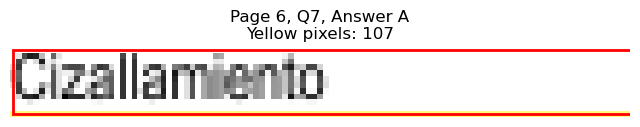

Page 6, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=191.2, y1=531.3
Page 6, Q7, B: Yellow pixels: 1459
Page 6, Q7, B: Total non-white pixels: 2088
Page 6, Q7, B: Yellow percentage: 69.9%


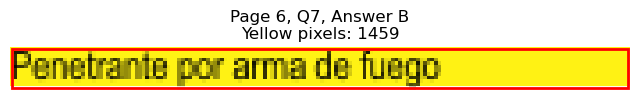

Page 6, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=429.2, y1=518.7
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 494
Page 6, Q7, C: Yellow percentage: 0.0%


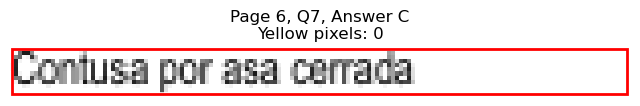

Page 6, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=441.8, y1=531.3
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 559
Page 6, Q7, D: Yellow percentage: 0.0%


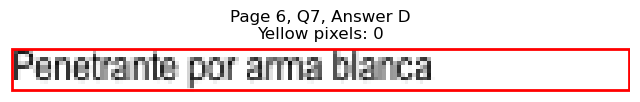


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=187.2, y1=607.0
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 598
Page 6, Q8, A: Yellow percentage: 0.0%


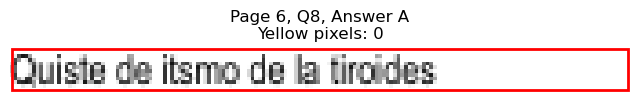

Page 6, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=172.7, y1=619.6
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 535
Page 6, Q8, B: Yellow percentage: 0.0%


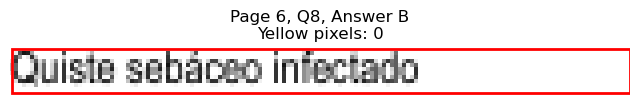

Page 6, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=446.4, y1=607.0
Page 6, Q8, C: Yellow pixels: 1586
Page 6, Q8, C: Total non-white pixels: 2043
Page 6, Q8, C: Yellow percentage: 77.6%


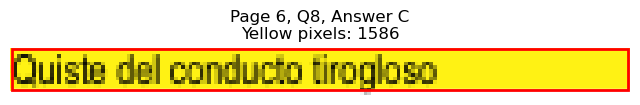

Page 6, Q8 - D: Detected box: x0=327.5, y0=608.6, x1=417.7, y1=619.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 435
Page 6, Q8, D: Yellow percentage: 0.0%


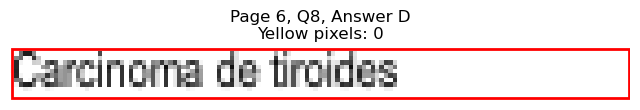


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=158.0, y1=682.8
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 439
Page 6, Q9, A: Yellow percentage: 0.0%


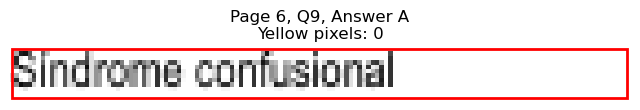

Page 6, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=98.0, y1=695.4
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 167
Page 6, Q9, B: Yellow percentage: 0.0%


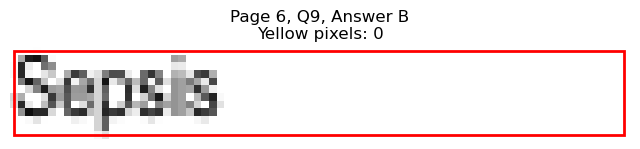

Page 6, Q9 - C: Detected box: x0=327.5, y0=671.7, x1=391.7, y1=682.8
Page 6, Q9, C: Yellow pixels: 115
Page 6, Q9, C: Total non-white pixels: 431
Page 6, Q9, C: Yellow percentage: 26.7%


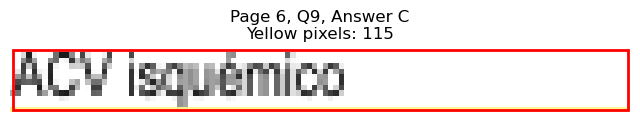

Page 6, Q9 - D: Detected box: x0=327.5, y0=684.3, x1=401.3, y1=695.4
Page 6, Q9, D: Yellow pixels: 1103
Page 6, Q9, D: Total non-white pixels: 1500
Page 6, Q9, D: Yellow percentage: 73.5%


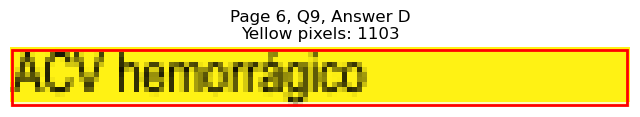


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=747.4, x1=181.7, y1=758.5
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 567
Page 6, Q10, A: Yellow percentage: 0.0%


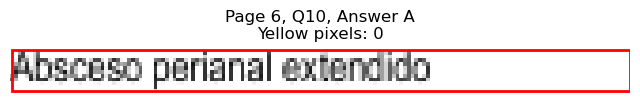

Page 6, Q10 - B: Detected box: x0=68.3, y0=760.2, x1=149.0, y1=771.2
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 423
Page 6, Q10, B: Yellow percentage: 0.0%


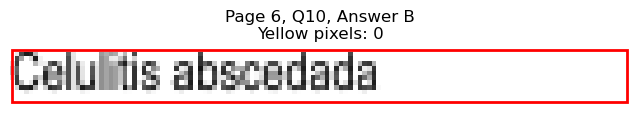

Page 6, Q10 - C: Detected box: x0=327.5, y0=747.4, x1=441.4, y1=758.5
Page 6, Q10, C: Yellow pixels: 165
Page 6, Q10, C: Total non-white pixels: 781
Page 6, Q10, C: Yellow percentage: 21.1%


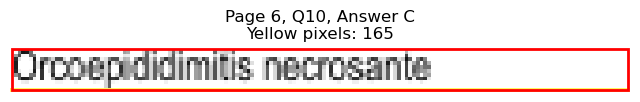

Page 6, Q10 - D: Detected box: x0=327.5, y0=760.2, x1=418.8, y1=771.2
Page 6, Q10, D: Yellow pixels: 1236
Page 6, Q10, D: Total non-white pixels: 1564
Page 6, Q10, D: Yellow percentage: 79.0%


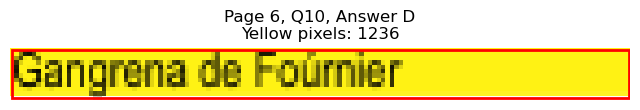


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=151.2, y1=114.8
Page 7, Q1, A: Yellow pixels: 1301
Page 7, Q1, A: Total non-white pixels: 1608
Page 7, Q1, A: Yellow percentage: 80.9%


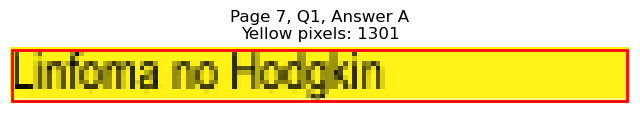

Page 7, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=151.1, y1=127.4
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 421
Page 7, Q1, B: Yellow percentage: 0.0%


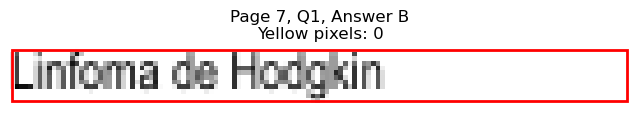

Page 7, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=399.7, y1=114.8
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 352
Page 7, Q1, C: Yellow percentage: 0.0%


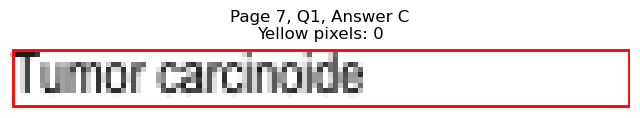

Page 7, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=449.4, y1=127.4
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 640
Page 7, Q1, D: Yellow percentage: 0.0%


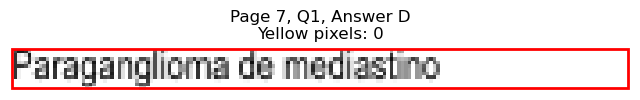


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=187.7, y1=177.9
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 600
Page 7, Q2, A: Yellow percentage: 0.0%


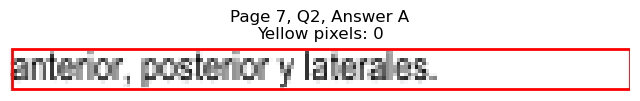

Page 7, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=148.6, y1=190.5
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 380
Page 7, Q2, B: Yellow percentage: 0.0%


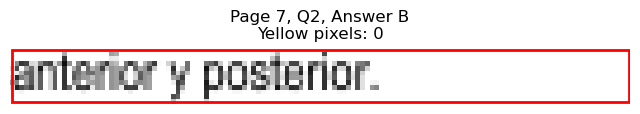

Page 7, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=436.3, y1=177.9
Page 7, Q2, C: Yellow pixels: 1518
Page 7, Q2, C: Total non-white pixels: 1920
Page 7, Q2, C: Yellow percentage: 79.1%


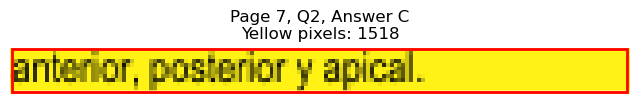

Page 7, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=411.2, y1=190.5
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 416
Page 7, Q2, D: Yellow percentage: 0.0%


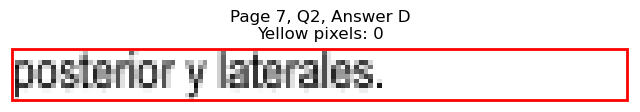


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=144.6, y1=253.6
Page 7, Q3, A: Yellow pixels: 1108
Page 7, Q3, A: Total non-white pixels: 1524
Page 7, Q3, A: Yellow percentage: 72.7%


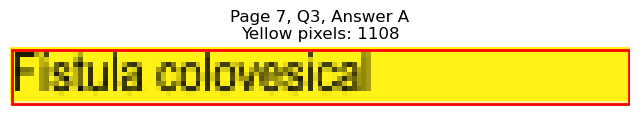

Page 7, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=136.0, y1=266.2
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 343
Page 7, Q3, B: Yellow percentage: 0.0%


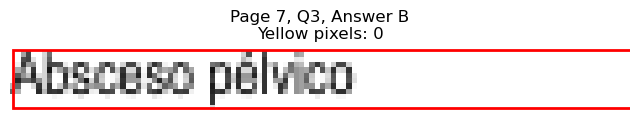

Page 7, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=413.8, y1=253.6
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 434
Page 7, Q3, C: Yellow percentage: 0.0%


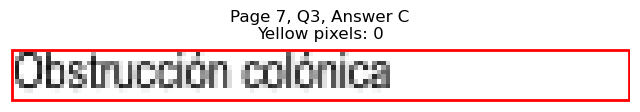

Page 7, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=398.8, y1=266.2
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 366
Page 7, Q3, D: Yellow percentage: 0.0%


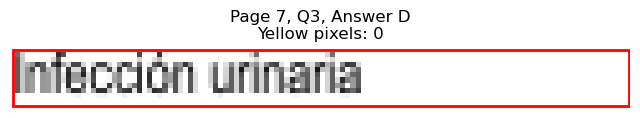


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=224.3, y1=304.2
Page 7, Q4, A: Yellow pixels: 207
Page 7, Q4, A: Total non-white pixels: 1223
Page 7, Q4, A: Yellow percentage: 16.9%


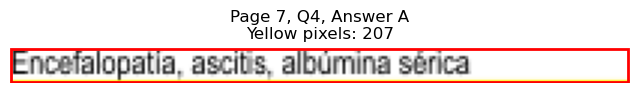

Page 7, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=313.9, y1=316.8
Page 7, Q4, B: Yellow pixels: 2642
Page 7, Q4, B: Total non-white pixels: 3552
Page 7, Q4, B: Yellow percentage: 74.4%


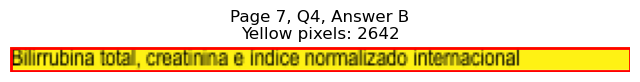

Page 7, Q4 - C: Detected box: x0=68.8, y0=318.3, x1=210.7, y1=329.4
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 739
Page 7, Q4, C: Yellow percentage: 0.0%


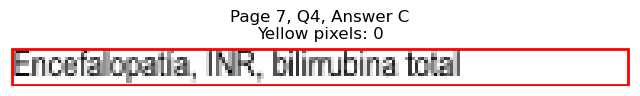

Page 7, Q4 - D: Detected box: x0=68.8, y0=330.9, x1=202.7, y1=342.0
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 679
Page 7, Q4, D: Yellow percentage: 0.0%


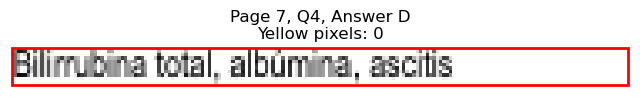


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=56.6, y0=394.0, x1=65.2, y1=405.1
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 44
Page 7, Q5, A: Yellow percentage: 0.0%


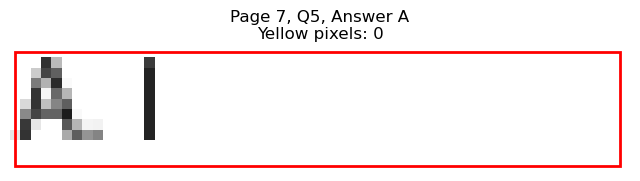

Page 7, Q5 - B: Detected box: x0=56.6, y0=406.6, x1=65.2, y1=417.7
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 66
Page 7, Q5, B: Yellow percentage: 0.0%


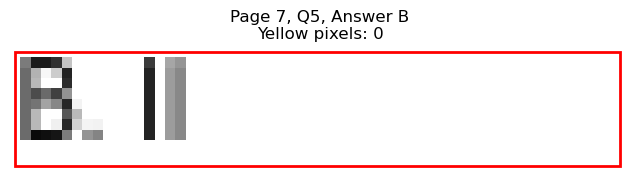

Page 7, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=337.6, y1=405.1
Page 7, Q5, C: Yellow pixels: 631
Page 7, Q5, C: Total non-white pixels: 671
Page 7, Q5, C: Yellow percentage: 94.0%


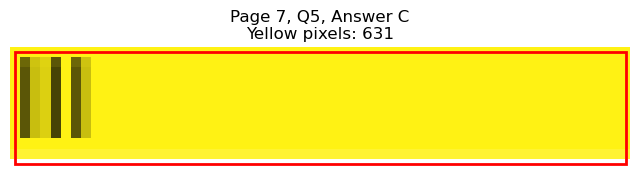

Page 7, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=338.5, y1=417.7
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 43
Page 7, Q5, D: Yellow percentage: 0.0%


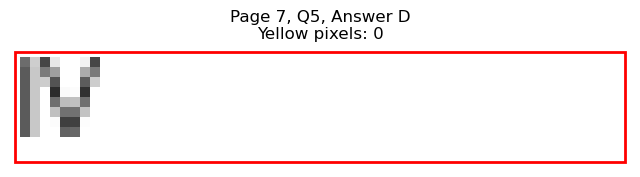


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=212.3, y1=468.2
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 705
Page 7, Q6, A: Yellow percentage: 0.0%


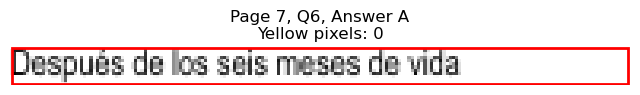

Page 7, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=250.0, y1=480.8
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 902
Page 7, Q6, B: Yellow percentage: 0.0%


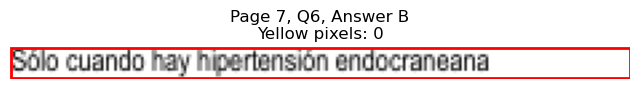

Page 7, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=502.9, y1=468.2
Page 7, Q6, C: Yellow pixels: 213
Page 7, Q6, C: Total non-white pixels: 1319
Page 7, Q6, C: Yellow percentage: 16.1%


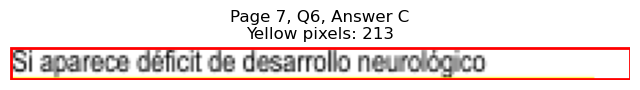

Page 7, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=493.0, y1=480.8
Page 7, Q6, D: Yellow pixels: 1938
Page 7, Q6, D: Total non-white pixels: 2556
Page 7, Q6, D: Yellow percentage: 75.8%


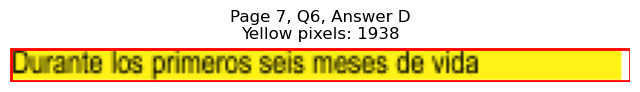


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=159.1, y1=556.5
Page 7, Q7, A: Yellow pixels: 1228
Page 7, Q7, A: Total non-white pixels: 1704
Page 7, Q7, A: Yellow percentage: 72.1%


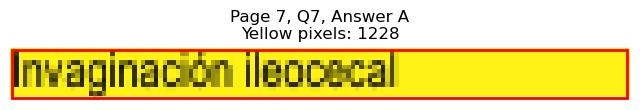

Page 7, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=192.6, y1=569.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 643
Page 7, Q7, B: Yellow percentage: 0.0%


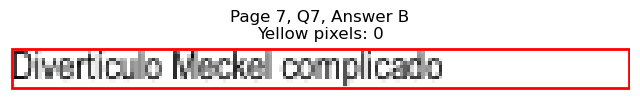

Page 7, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=412.2, y1=556.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 448
Page 7, Q7, C: Yellow percentage: 0.0%


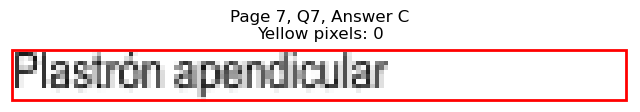

Page 7, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=455.9, y1=569.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 644
Page 7, Q7, D: Yellow percentage: 0.0%


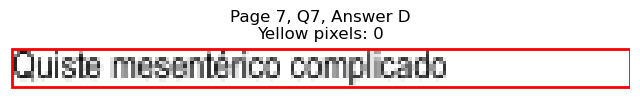


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=151.6, y1=607.0
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 420
Page 7, Q8, A: Yellow percentage: 0.0%


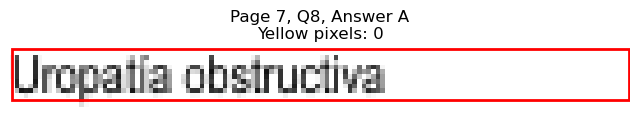

Page 7, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=168.1, y1=619.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 539
Page 7, Q8, B: Yellow percentage: 0.0%


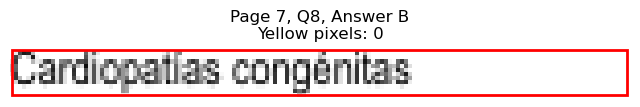

Page 7, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=472.4, y1=607.0
Page 7, Q8, C: Yellow pixels: 1793
Page 7, Q8, C: Total non-white pixels: 2355
Page 7, Q8, C: Yellow percentage: 76.1%


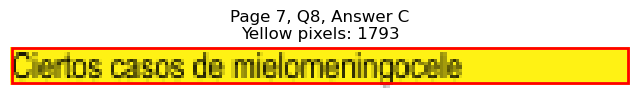

Page 7, Q8 - D: Detected box: x0=327.5, y0=608.6, x1=454.9, y1=619.6
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 711
Page 7, Q8, D: Yellow percentage: 0.0%


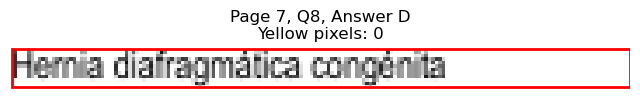


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=173.6, y1=682.8
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 527
Page 7, Q9, A: Yellow percentage: 0.0%


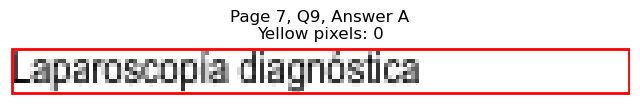

Page 7, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=167.6, y1=695.4
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 493
Page 7, Q9, B: Yellow percentage: 0.0%


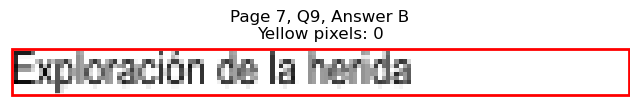

Page 7, Q9 - C: Detected box: x0=327.5, y0=671.7, x1=430.3, y1=682.8
Page 7, Q9, C: Yellow pixels: 1454
Page 7, Q9, C: Total non-white pixels: 1848
Page 7, Q9, C: Yellow percentage: 78.7%


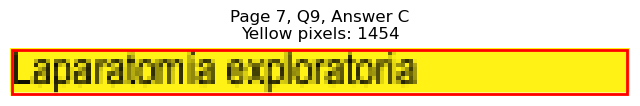

Page 7, Q9 - D: Detected box: x0=327.5, y0=684.3, x1=353.0, y1=695.4
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 119
Page 7, Q9, D: Yellow percentage: 0.0%


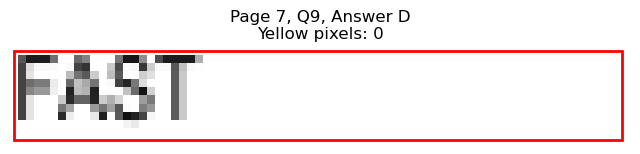


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=747.4, x1=147.0, y1=758.5
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 398
Page 7, Q10, A: Yellow percentage: 0.0%


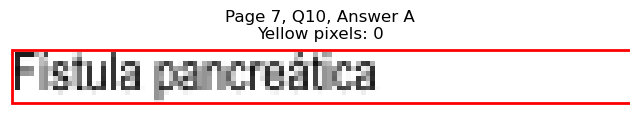

Page 7, Q10 - B: Detected box: x0=68.3, y0=760.2, x1=190.2, y1=771.2
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 590
Page 7, Q10, B: Yellow percentage: 0.0%


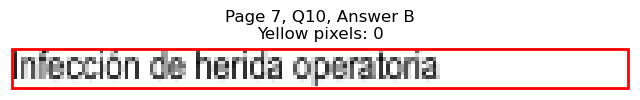

Page 7, Q10 - C: Detected box: x0=327.5, y0=747.4, x1=460.8, y1=758.5
Page 7, Q10, C: Yellow pixels: 1508
Page 7, Q10, C: Total non-white pixels: 2208
Page 7, Q10, C: Yellow percentage: 68.3%


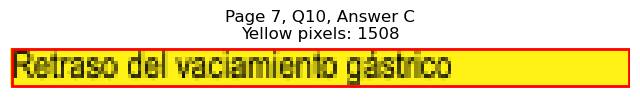

Page 7, Q10 - D: Detected box: x0=327.5, y0=760.2, x1=369.7, y1=771.2
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 234
Page 7, Q10, D: Yellow percentage: 0.0%


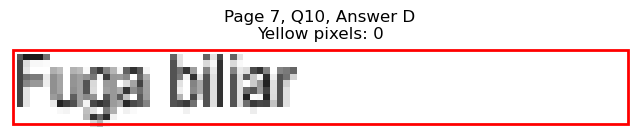


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=91.2, x1=65.2, y1=102.2
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 68
Page 8, Q1, A: Yellow percentage: 0.0%


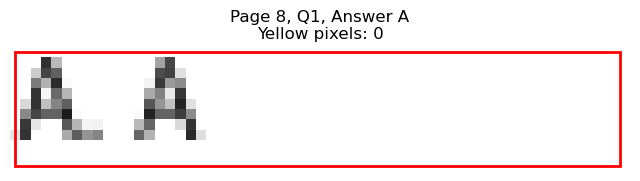

Page 8, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=82.8, y1=114.8
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 72
Page 8, Q1, B: Yellow percentage: 0.0%


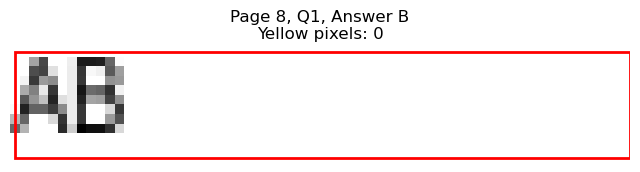

Page 8, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=341.0, y1=102.2
Page 8, Q1, C: Yellow pixels: 667
Page 8, Q1, C: Total non-white pixels: 715
Page 8, Q1, C: Yellow percentage: 93.3%


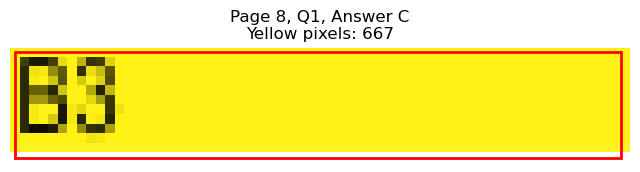

Page 8, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=341.0, y1=114.8
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 50
Page 8, Q1, D: Yellow percentage: 0.0%


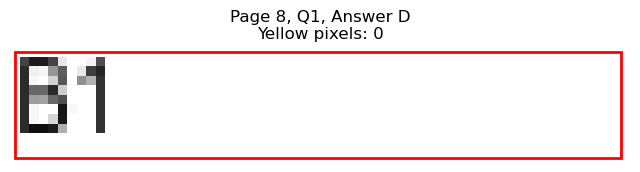


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=97.0, y1=190.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 102
Page 8, Q2, A: Yellow percentage: 0.0%


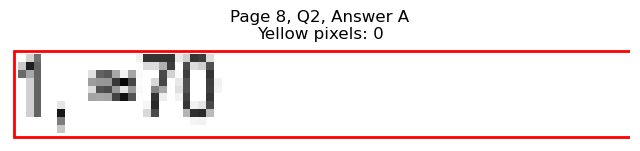

Page 8, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=97.0, y1=203.1
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 112
Page 8, Q2, B: Yellow percentage: 0.0%


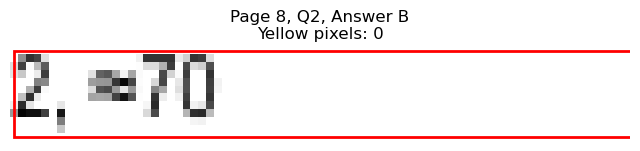

Page 8, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=356.2, y1=190.5
Page 8, Q2, C: Yellow pixels: 800
Page 8, Q2, C: Total non-white pixels: 960
Page 8, Q2, C: Yellow percentage: 83.3%


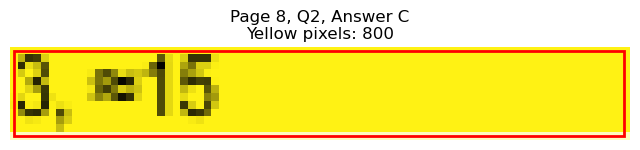

Page 8, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=356.2, y1=203.1
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 117
Page 8, Q2, D: Yellow percentage: 0.0%


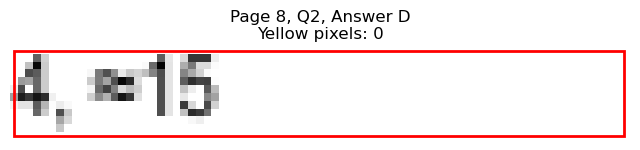


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=81.8, y1=241.0
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 63
Page 8, Q3, A: Yellow percentage: 0.0%


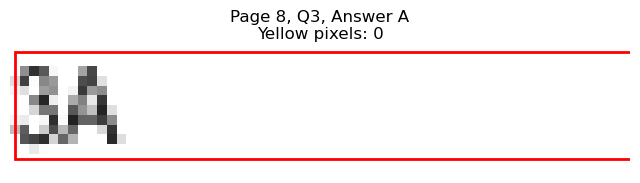

Page 8, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=81.8, y1=253.6
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 72
Page 8, Q3, B: Yellow percentage: 0.0%


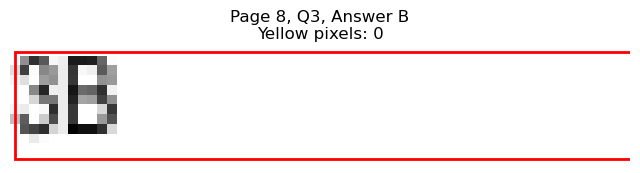

Page 8, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=341.0, y1=241.0
Page 8, Q3, C: Yellow pixels: 732
Page 8, Q3, C: Total non-white pixels: 780
Page 8, Q3, C: Yellow percentage: 93.8%


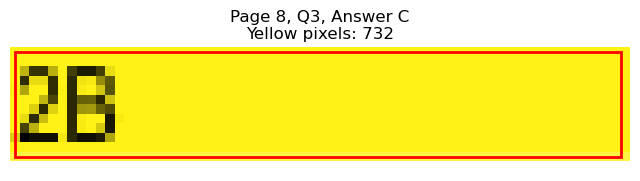

Page 8, Q3 - D: Detected box: x0=315.4, y0=242.6, x1=324.4, y1=253.6
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 72
Page 8, Q3, D: Yellow percentage: 0.0%


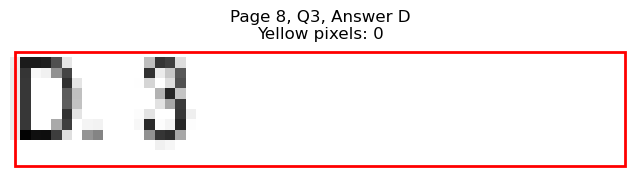


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=108.4, y1=304.2
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 199
Page 8, Q4, A: Yellow percentage: 0.0%


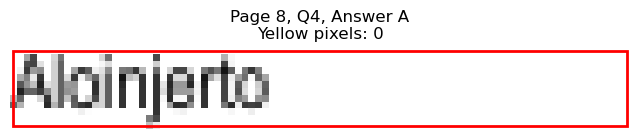

Page 8, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=119.4, y1=316.8
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 240
Page 8, Q4, B: Yellow percentage: 0.0%


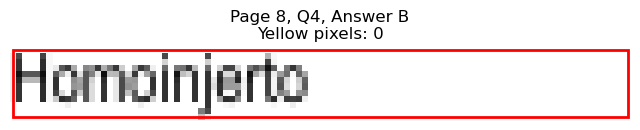

Page 8, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=373.1, y1=304.2
Page 8, Q4, C: Yellow pixels: 888
Page 8, Q4, C: Total non-white pixels: 1070
Page 8, Q4, C: Yellow percentage: 83.0%


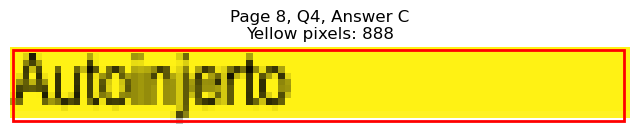

Page 8, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=375.6, y1=316.8
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 249
Page 8, Q4, D: Yellow percentage: 0.0%


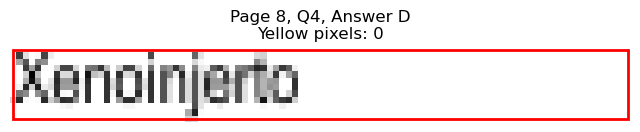


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=133.1, y1=392.5
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 348
Page 8, Q5, A: Yellow percentage: 0.0%


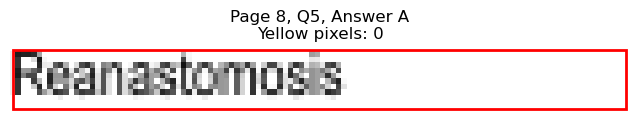

Page 8, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=196.2, y1=405.1
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 655
Page 8, Q5, B: Yellow percentage: 0.0%


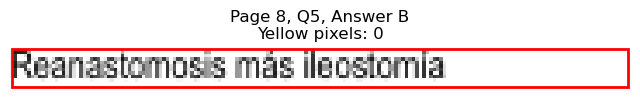

Page 8, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=428.8, y1=392.5
Page 8, Q5, C: Yellow pixels: 152
Page 8, Q5, C: Total non-white pixels: 657
Page 8, Q5, C: Yellow percentage: 23.1%


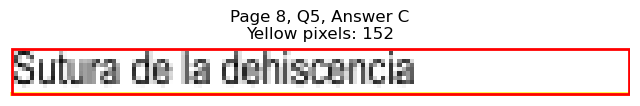

Page 8, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=416.8, y1=405.1
Page 8, Q5, D: Yellow pixels: 1197
Page 8, Q5, D: Total non-white pixels: 1540
Page 8, Q5, D: Yellow percentage: 77.7%


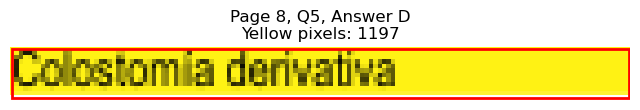


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=274.9, y1=455.6
Page 8, Q6, A: Yellow pixels: 96
Page 8, Q6, A: Total non-white pixels: 1177
Page 8, Q6, A: Yellow percentage: 8.2%


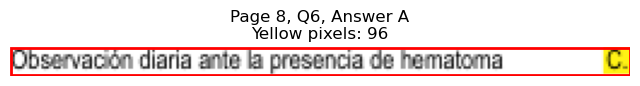

Page 8, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=253.3, y1=468.2
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 932
Page 8, Q6, B: Yellow percentage: 0.0%


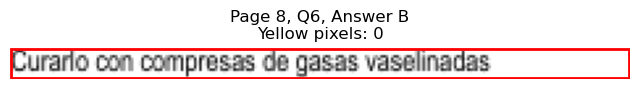

Page 8, Q6 - C: Detected box: x0=327.5, y0=444.6, x1=455.9, y1=455.6
Page 8, Q6, C: Yellow pixels: 1487
Page 8, Q6, C: Total non-white pixels: 2148
Page 8, Q6, C: Yellow percentage: 69.2%


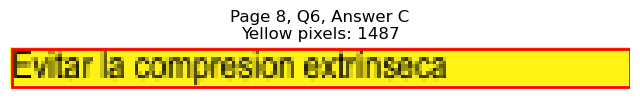

Page 8, Q6 - D: Detected box: x0=327.5, y0=457.2, x1=474.0, y1=468.2
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 765
Page 8, Q6, D: Yellow percentage: 0.0%


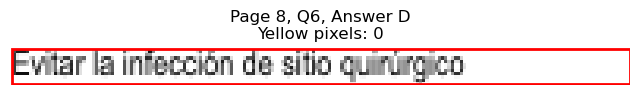


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=495.1, x1=189.6, y1=506.1
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 569
Page 8, Q7, A: Yellow percentage: 0.0%


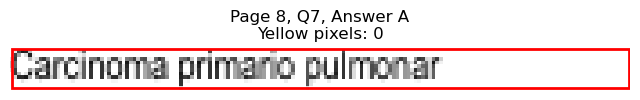

Page 8, Q7 - B: Detected box: x0=68.3, y0=507.7, x1=102.8, y1=518.7
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 167
Page 8, Q7, B: Yellow percentage: 0.0%


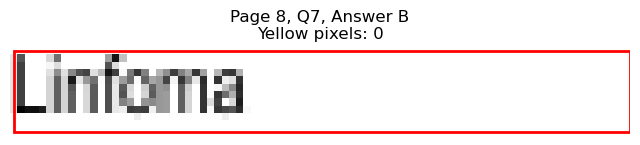

Page 8, Q7 - C: Detected box: x0=327.5, y0=495.1, x1=461.9, y1=506.1
Page 8, Q7, C: Yellow pixels: 1503
Page 8, Q7, C: Total non-white pixels: 2038
Page 8, Q7, C: Yellow percentage: 73.7%


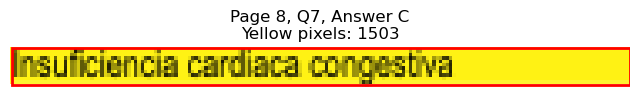

Page 8, Q7 - D: Detected box: x0=327.5, y0=507.7, x1=381.1, y1=518.7
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 290
Page 8, Q7, D: Yellow percentage: 0.0%


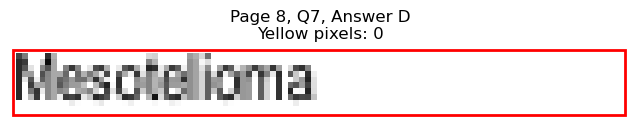


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=132.0, y1=569.2
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 310
Page 8, Q8, A: Yellow percentage: 0.0%


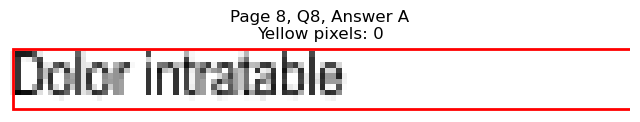

Page 8, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=138.0, y1=581.8
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 330
Page 8, Q8, B: Yellow percentage: 0.0%


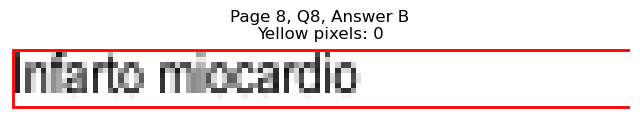

Page 8, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=417.2, y1=569.2
Page 8, Q8, C: Yellow pixels: 1200
Page 8, Q8, C: Total non-white pixels: 1551
Page 8, Q8, C: Yellow percentage: 77.4%


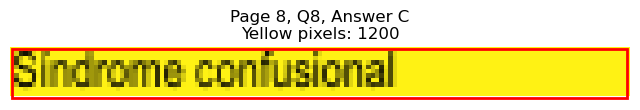

Page 8, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=429.8, y1=581.8
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 532
Page 8, Q8, D: Yellow percentage: 0.0%


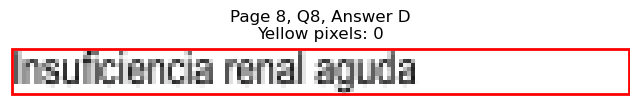


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=108.4, y1=619.6
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 201
Page 8, Q9, A: Yellow percentage: 0.0%


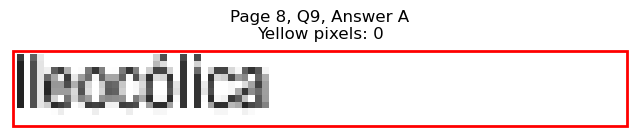

Page 8, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=122.4, y1=632.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 265
Page 8, Q9, B: Yellow percentage: 0.0%


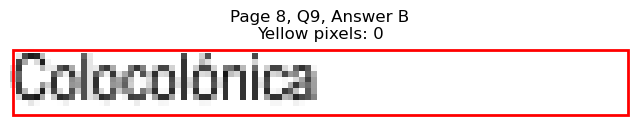

Page 8, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=360.6, y1=619.6
Page 8, Q9, C: Yellow pixels: 84
Page 8, Q9, C: Total non-white pixels: 275
Page 8, Q9, C: Yellow percentage: 30.5%


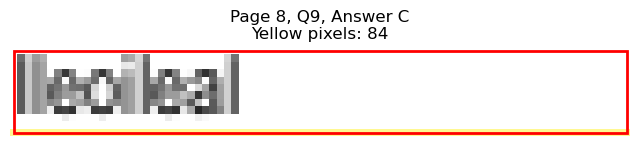

Page 8, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=373.6, y1=632.4
Page 8, Q9, D: Yellow pixels: 866
Page 8, Q9, D: Total non-white pixels: 1164
Page 8, Q9, D: Yellow percentage: 74.4%


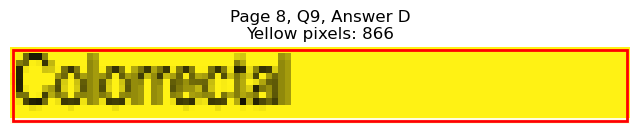


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=121.9, y1=682.8
Page 8, Q10, A: Yellow pixels: 104
Page 8, Q10, A: Total non-white pixels: 392
Page 8, Q10, A: Yellow percentage: 26.5%


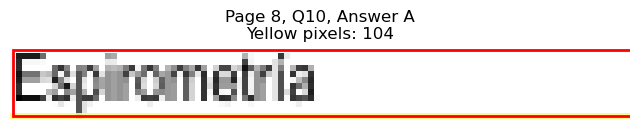

Page 8, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=177.6, y1=695.4
Page 8, Q10, B: Yellow pixels: 1363
Page 8, Q10, B: Total non-white pixels: 1920
Page 8, Q10, B: Yellow percentage: 71.0%


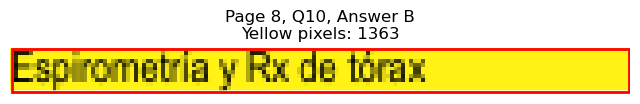

Page 8, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=395.6, y1=682.8
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 353
Page 8, Q10, C: Yellow percentage: 0.0%


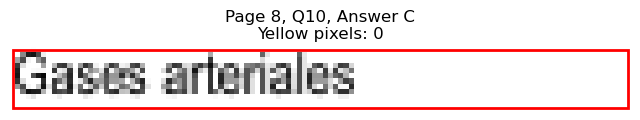

Page 8, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=472.9, y1=695.4
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 732
Page 8, Q10, D: Yellow percentage: 0.0%


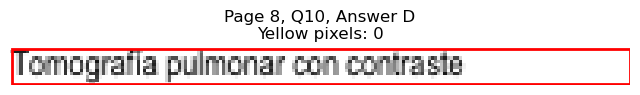


Page 8, Q10 - Selected Answer: B (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=120.6, y1=745.9
Page 8, Q11, A: Yellow pixels: 1020
Page 8, Q11, A: Total non-white pixels: 1236
Page 8, Q11, A: Yellow percentage: 82.5%


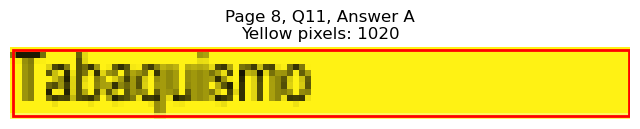

Page 8, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=147.0, y1=758.5
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 413
Page 8, Q11, B: Yellow percentage: 0.0%


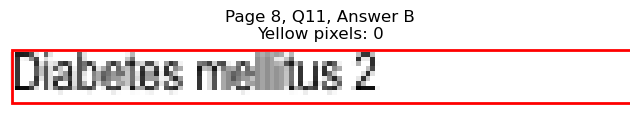

Page 8, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=396.7, y1=745.9
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 369
Page 8, Q11, C: Yellow percentage: 0.0%


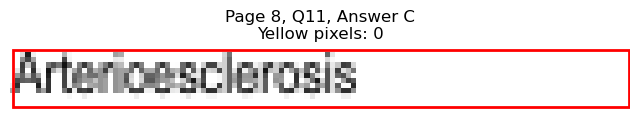

Page 8, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=351.1, y1=758.5
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 111
Page 8, Q11, D: Yellow percentage: 0.0%


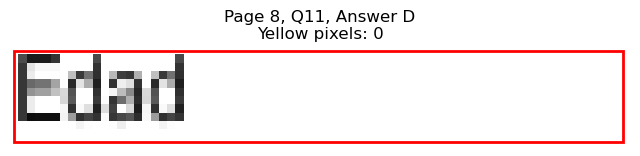


Page 8, Q11 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=381.4, x1=195.7, y1=392.5
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 924
Page 9, Q1, A: Yellow percentage: 0.0%


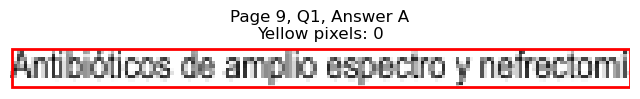

Page 9, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=150.1, y1=140.0
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 428
Page 9, Q1, B: Yellow percentage: 0.0%


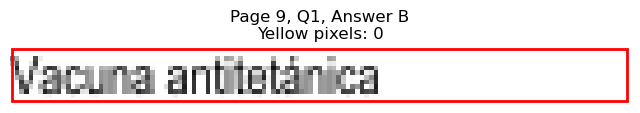

Page 9, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=421.8, y1=127.4
Page 9, Q1, C: Yellow pixels: 145
Page 9, Q1, C: Total non-white pixels: 640
Page 9, Q1, C: Yellow percentage: 22.7%


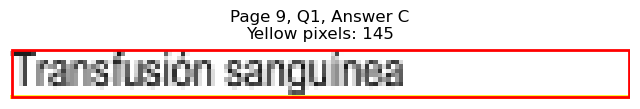

Page 9, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=433.0, y1=140.0
Page 9, Q1, D: Yellow pixels: 1486
Page 9, Q1, D: Total non-white pixels: 1872
Page 9, Q1, D: Yellow percentage: 79.4%


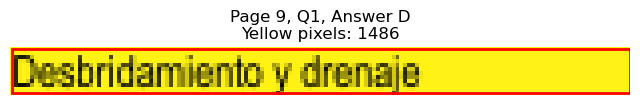


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=161.6, y1=177.9
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 429
Page 9, Q2, A: Yellow percentage: 0.0%


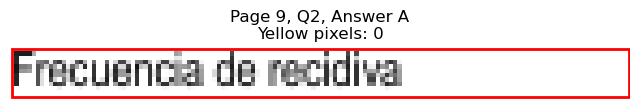

Page 9, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=182.2, y1=190.5
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 592
Page 9, Q2, B: Yellow percentage: 0.0%


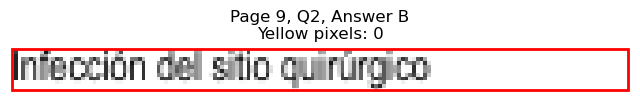

Page 9, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=464.4, y1=177.9
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 886
Page 9, Q2, C: Yellow percentage: 0.0%


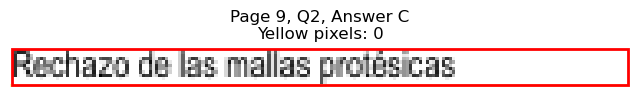

Page 9, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=414.2, y1=190.5
Page 9, Q2, D: Yellow pixels: 1197
Page 9, Q2, D: Total non-white pixels: 1656
Page 9, Q2, D: Yellow percentage: 72.3%


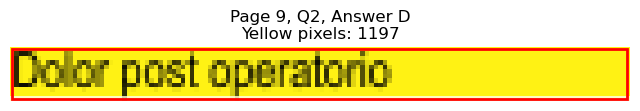


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=135.6, y1=241.0
Page 9, Q3, A: Yellow pixels: 1155
Page 9, Q3, A: Total non-white pixels: 1418
Page 9, Q3, A: Yellow percentage: 81.5%


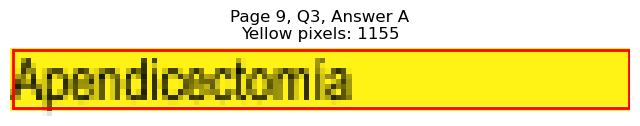

Page 9, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=165.6, y1=253.6
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 492
Page 9, Q3, B: Yellow percentage: 0.0%


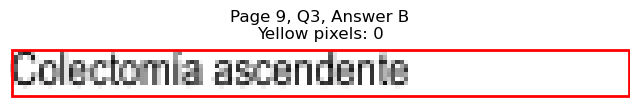

Page 9, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=429.8, y1=241.0
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 525
Page 9, Q3, C: Yellow percentage: 0.0%


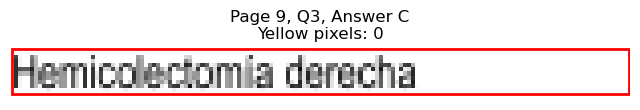

Page 9, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=371.6, y1=253.6
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 234
Page 9, Q3, D: Yellow percentage: 0.0%


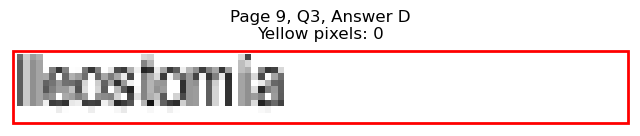


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=174.6, y1=304.2
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 568
Page 9, Q4, A: Yellow percentage: 0.0%


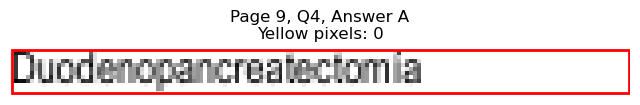

Page 9, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=145.6, y1=316.8
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 380
Page 9, Q4, B: Yellow percentage: 0.0%


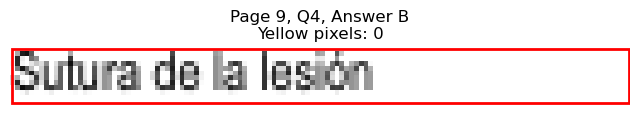

Page 9, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=407.3, y1=304.2
Page 9, Q4, C: Yellow pixels: 131
Page 9, Q4, C: Total non-white pixels: 649
Page 9, Q4, C: Yellow percentage: 20.2%


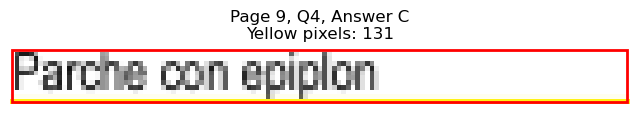

Page 9, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=421.8, y1=316.8
Page 9, Q4, D: Yellow pixels: 1376
Page 9, Q4, D: Total non-white pixels: 1740
Page 9, Q4, D: Yellow percentage: 79.1%


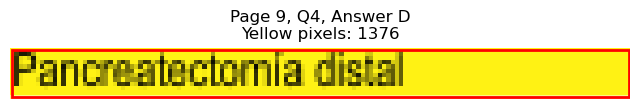


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=285.0, y1=392.5
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 1117
Page 9, Q5, A: Yellow percentage: 0.0%


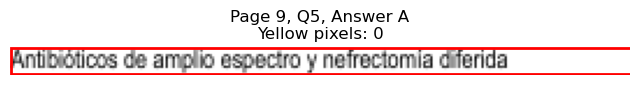

Page 9, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=285.5, y1=405.1
Page 9, Q5, B: Yellow pixels: 268
Page 9, Q5, B: Total non-white pixels: 1639
Page 9, Q5, B: Yellow percentage: 16.4%


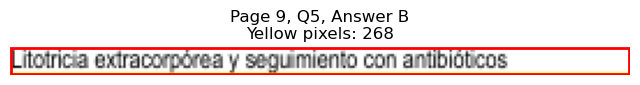

Page 9, Q5 - C: Detected box: x0=68.8, y0=406.6, x1=363.2, y1=417.7
Page 9, Q5, C: Yellow pixels: 3014
Page 9, Q5, C: Total non-white pixels: 4152
Page 9, Q5, C: Yellow percentage: 72.6%


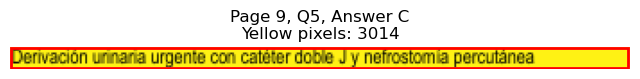

Page 9, Q5 - D: Detected box: x0=68.8, y0=419.4, x1=286.0, y1=430.4
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 1105
Page 9, Q5, D: Yellow percentage: 0.0%


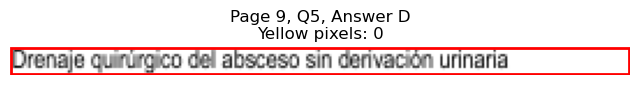


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=482.5, x1=203.2, y1=493.5
Page 9, Q6, A: Yellow pixels: 186
Page 9, Q6, A: Total non-white pixels: 886
Page 9, Q6, A: Yellow percentage: 21.0%


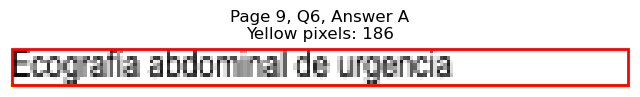

Page 9, Q6 - B: Detected box: x0=68.3, y0=495.1, x1=186.1, y1=506.1
Page 9, Q6, B: Yellow pixels: 1406
Page 9, Q6, B: Total non-white pixels: 1864
Page 9, Q6, B: Yellow percentage: 75.4%


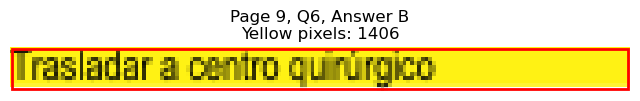

Page 9, Q6 - C: Detected box: x0=327.5, y0=482.5, x1=451.3, y1=493.5
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 586
Page 9, Q6, C: Yellow percentage: 0.0%


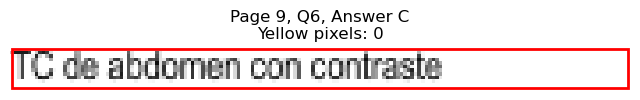

Page 9, Q6 - D: Detected box: x0=327.5, y0=495.1, x1=431.3, y1=506.1
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 541
Page 9, Q6, D: Yellow percentage: 0.0%


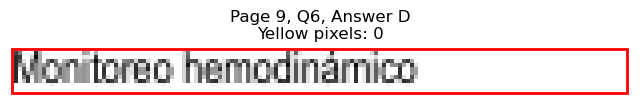


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=532.9, x1=185.6, y1=543.9
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 584
Page 9, Q7, A: Yellow percentage: 0.0%


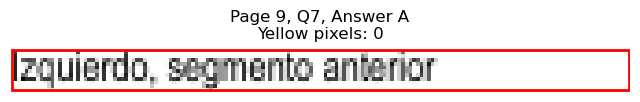

Page 9, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=182.6, y1=556.5
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 570
Page 9, Q7, B: Yellow percentage: 0.0%


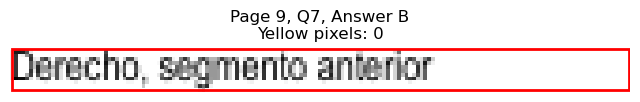

Page 9, Q7 - C: Detected box: x0=327.5, y0=532.9, x1=449.4, y1=543.9
Page 9, Q7, C: Yellow pixels: 1
Page 9, Q7, C: Total non-white pixels: 784
Page 9, Q7, C: Yellow percentage: 0.1%


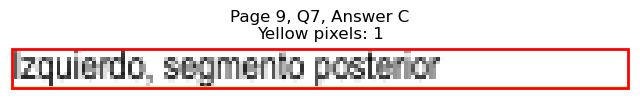

Page 9, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=446.3, y1=556.5
Page 9, Q7, D: Yellow pixels: 1399
Page 9, Q7, D: Total non-white pixels: 2040
Page 9, Q7, D: Yellow percentage: 68.6%


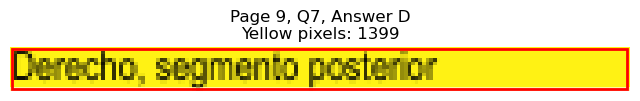


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=183.7, y1=619.6
Page 9, Q8, A: Yellow pixels: 1551
Page 9, Q8, A: Total non-white pixels: 1992
Page 9, Q8, A: Yellow percentage: 77.9%


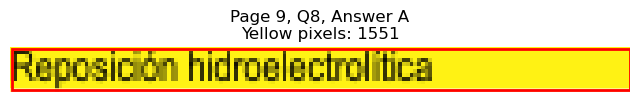

Page 9, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=150.6, y1=632.4
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 429
Page 9, Q8, B: Yellow percentage: 0.0%


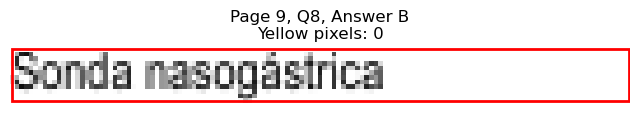

Page 9, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=407.8, y1=619.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 427
Page 9, Q8, C: Yellow percentage: 0.0%


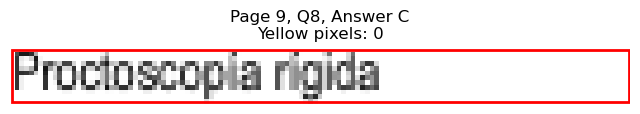

Page 9, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=398.6, y1=632.4
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 330
Page 9, Q8, D: Yellow percentage: 0.0%


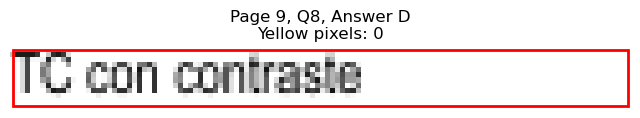


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=209.2, y1=682.8
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 699
Page 9, Q9, A: Yellow percentage: 0.0%


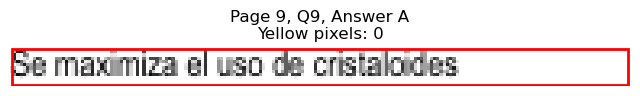

Page 9, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=289.4, y1=695.4
Page 9, Q9, B: Yellow pixels: 272
Page 9, Q9, B: Total non-white pixels: 1361
Page 9, Q9, B: Yellow percentage: 20.0%


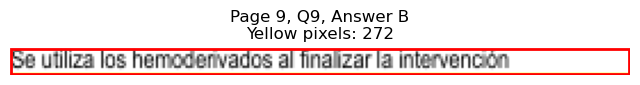

Page 9, Q9 - C: Detected box: x0=68.8, y0=697.0, x1=390.2, y1=708.1
Page 9, Q9, C: Yellow pixels: 2848
Page 9, Q9, C: Total non-white pixels: 4115
Page 9, Q9, C: Yellow percentage: 69.2%


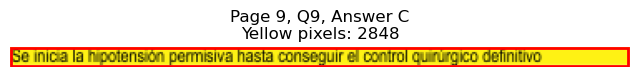

Page 9, Q9 - D: Detected box: x0=68.8, y0=709.6, x1=226.3, y1=720.7
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 795
Page 9, Q9, D: Yellow percentage: 0.0%


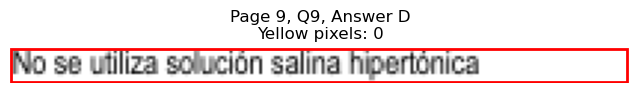


Page 9, Q9 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=158.0, y1=114.8
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 414
Page 10, Q1, A: Yellow percentage: 0.0%


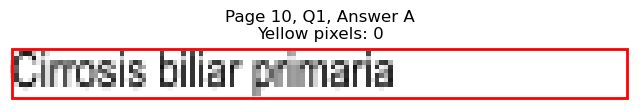

Page 10, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=158.5, y1=127.4
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 454
Page 10, Q1, B: Yellow percentage: 0.0%


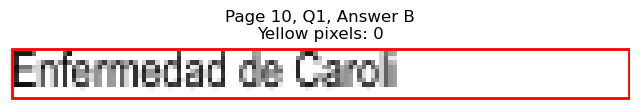

Page 10, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=421.8, y1=114.8
Page 10, Q1, C: Yellow pixels: 1354
Page 10, Q1, C: Total non-white pixels: 1740
Page 10, Q1, C: Yellow percentage: 77.8%


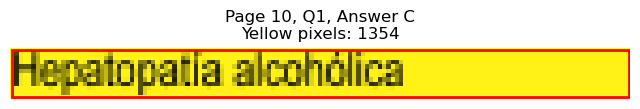

Page 10, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=407.3, y1=127.4
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 388
Page 10, Q1, D: Yellow percentage: 0.0%


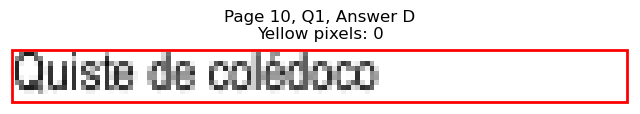


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=212.3, y1=165.3
Page 10, Q2, A: Yellow pixels: 195
Page 10, Q2, A: Total non-white pixels: 917
Page 10, Q2, A: Yellow percentage: 21.3%


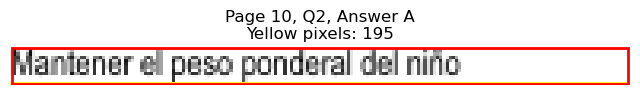

Page 10, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=181.2, y1=177.9
Page 10, Q2, B: Yellow pixels: 1555
Page 10, Q2, B: Total non-white pixels: 1968
Page 10, Q2, B: Yellow percentage: 79.0%


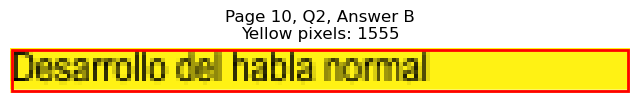

Page 10, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=400.7, y1=165.3
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 352
Page 10, Q2, C: Yellow percentage: 0.0%


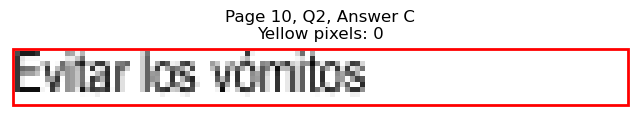

Page 10, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=362.0, y1=177.9
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 194
Page 10, Q2, D: Yellow percentage: 0.0%


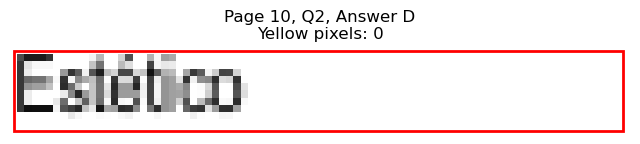


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=56.6, y0=230.0, x1=65.2, y1=241.0
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 44
Page 10, Q3, A: Yellow percentage: 0.0%


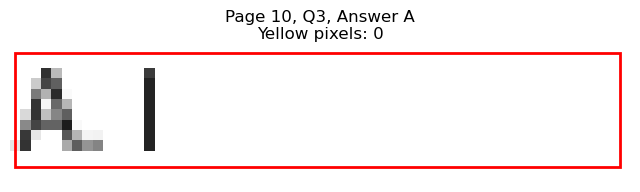

Page 10, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=78.4, y1=253.6
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 32
Page 10, Q3, B: Yellow percentage: 0.0%


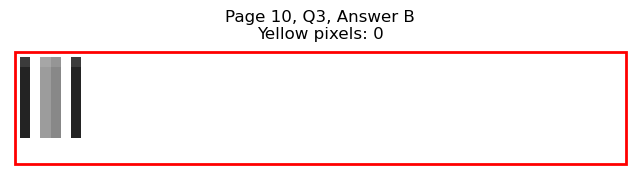

Page 10, Q3 - C: Detected box: x0=315.4, y0=230.0, x1=324.4, y1=241.0
Page 10, Q3, C: Yellow pixels: 675
Page 10, Q3, C: Total non-white pixels: 720
Page 10, Q3, C: Yellow percentage: 93.8%


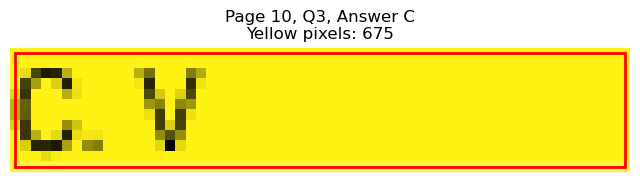

Page 10, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=338.5, y1=253.6
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 43
Page 10, Q3, D: Yellow percentage: 0.0%


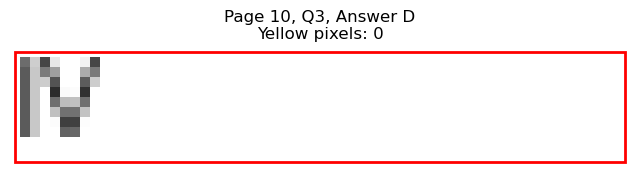


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=146.6, y1=304.2
Page 10, Q4, A: Yellow pixels: 129
Page 10, Q4, A: Total non-white pixels: 646
Page 10, Q4, A: Yellow percentage: 20.0%


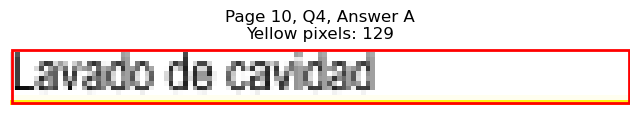

Page 10, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=165.1, y1=316.8
Page 10, Q4, B: Yellow pixels: 1403
Page 10, Q4, B: Total non-white pixels: 1776
Page 10, Q4, B: Yellow percentage: 79.0%


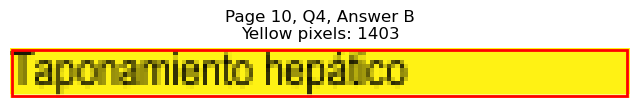

Page 10, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=446.4, y1=304.2
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 605
Page 10, Q4, C: Yellow percentage: 0.0%


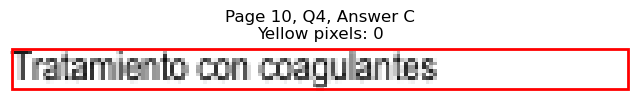

Page 10, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=470.4, y1=316.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 755
Page 10, Q4, D: Yellow percentage: 0.0%


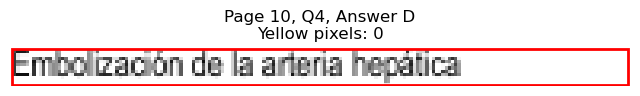


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=162.0, y1=392.5
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 461
Page 10, Q5, A: Yellow percentage: 0.0%


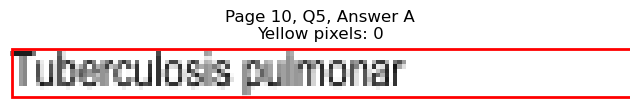

Page 10, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=162.1, y1=405.1
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 493
Page 10, Q5, B: Yellow percentage: 0.0%


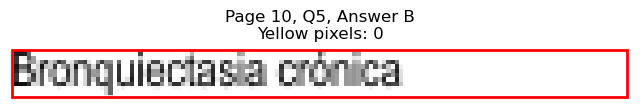

Page 10, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=404.8, y1=392.5
Page 10, Q5, C: Yellow pixels: 1133
Page 10, Q5, C: Total non-white pixels: 1536
Page 10, Q5, C: Yellow percentage: 73.8%


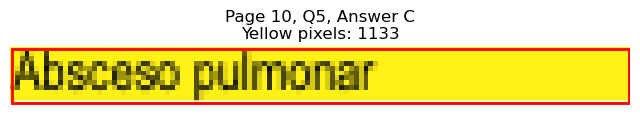

Page 10, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=403.7, y1=405.1
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 378
Page 10, Q5, D: Yellow percentage: 0.0%


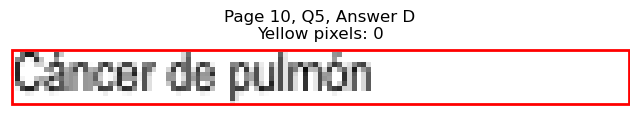


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=317.2, y1=455.6
Page 10, Q6, A: Yellow pixels: 300
Page 10, Q6, A: Total non-white pixels: 1525
Page 10, Q6, A: Yellow percentage: 19.7%


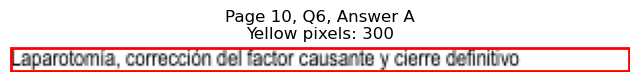

Page 10, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=385.3, y1=468.2
Page 10, Q6, B: Yellow pixels: 2874
Page 10, Q6, B: Total non-white pixels: 4058
Page 10, Q6, B: Yellow percentage: 70.8%


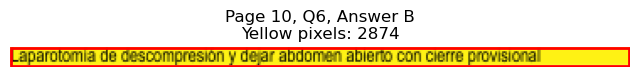

Page 10, Q6 - C: Detected box: x0=68.8, y0=469.8, x1=245.3, y1=480.8
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 887
Page 10, Q6, C: Yellow percentage: 0.0%


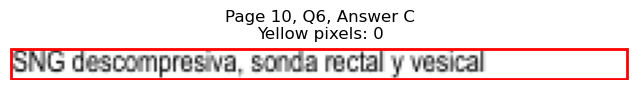

Page 10, Q6 - D: Detected box: x0=68.8, y0=482.5, x1=301.6, y1=493.5
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 1188
Page 10, Q6, D: Yellow percentage: 0.0%


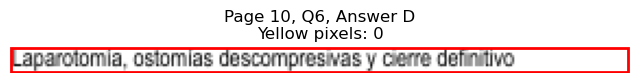


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=532.9, x1=139.6, y1=543.9
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 343
Page 10, Q7, A: Yellow percentage: 0.0%


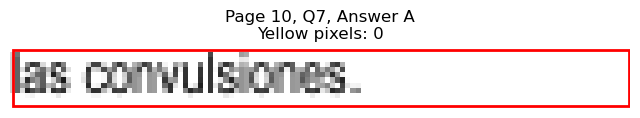

Page 10, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=102.8, y1=556.5
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 163
Page 10, Q7, B: Yellow percentage: 0.0%


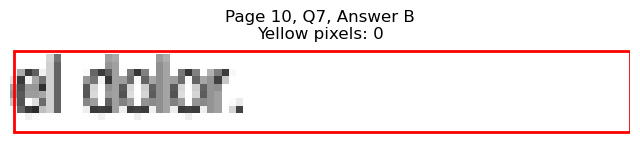

Page 10, Q7 - C: Detected box: x0=327.5, y0=532.9, x1=412.8, y1=543.9
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 577
Page 10, Q7, C: Yellow percentage: 0.0%


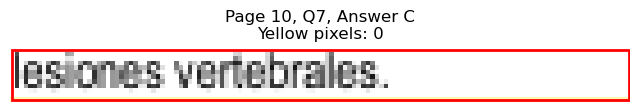

Page 10, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=442.3, y1=556.5
Page 10, Q7, D: Yellow pixels: 1402
Page 10, Q7, D: Total non-white pixels: 1992
Page 10, Q7, D: Yellow percentage: 70.4%


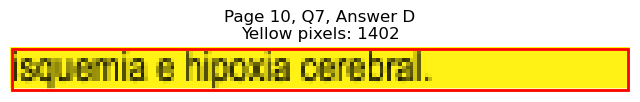


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=621.3, x1=112.9, y1=632.4
Page 10, Q8, A: Yellow pixels: 95
Page 10, Q8, A: Total non-white pixels: 328
Page 10, Q8, A: Yellow percentage: 29.0%


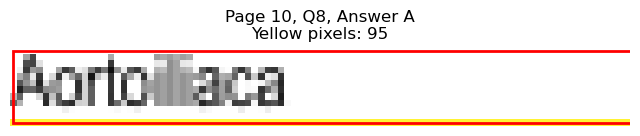

Page 10, Q8 - B: Detected box: x0=68.3, y0=633.9, x1=134.0, y1=645.0
Page 10, Q8, B: Yellow pixels: 1161
Page 10, Q8, B: Total non-white pixels: 1404
Page 10, Q8, B: Yellow percentage: 82.7%


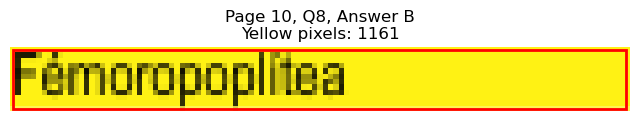

Page 10, Q8 - C: Detected box: x0=327.5, y0=621.3, x1=358.1, y1=632.4
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 156
Page 10, Q8, C: Yellow percentage: 0.0%


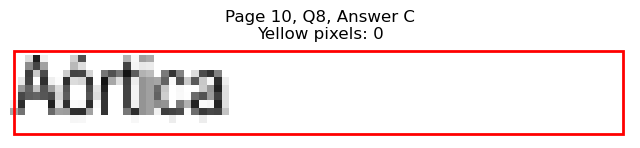

Page 10, Q8 - D: Detected box: x0=327.5, y0=633.9, x1=351.1, y1=645.0
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 128
Page 10, Q8, D: Yellow percentage: 0.0%


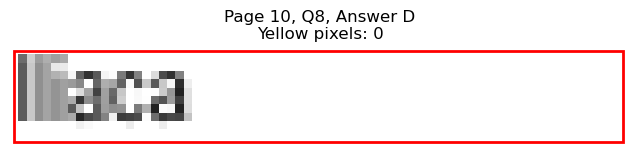


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=684.3, x1=86.4, y1=695.4
Page 10, Q9, A: Yellow pixels: 717
Page 10, Q9, A: Total non-white pixels: 828
Page 10, Q9, A: Yellow percentage: 86.6%


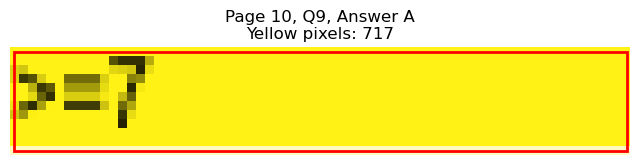

Page 10, Q9 - B: Detected box: x0=68.3, y0=697.0, x1=90.8, y1=708.1
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 86
Page 10, Q9, B: Yellow percentage: 0.0%


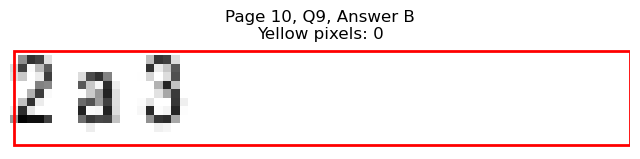

Page 10, Q9 - C: Detected box: x0=327.5, y0=684.3, x1=350.0, y1=695.4
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 95
Page 10, Q9, C: Yellow percentage: 0.0%


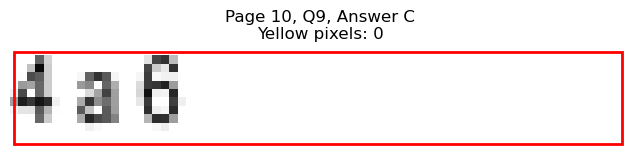

Page 10, Q9 - D: Detected box: x0=315.4, y0=697.0, x1=324.4, y1=708.1
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 55
Page 10, Q9, D: Yellow percentage: 0.0%


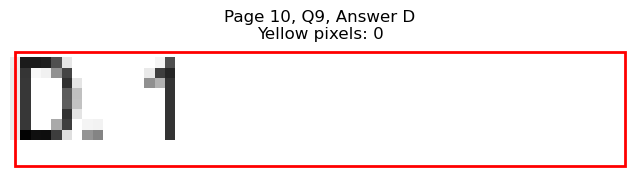


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=56.6, y0=230.0, x1=65.2, y1=241.0
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 44
Page 10, Q10, A: Yellow percentage: 0.0%


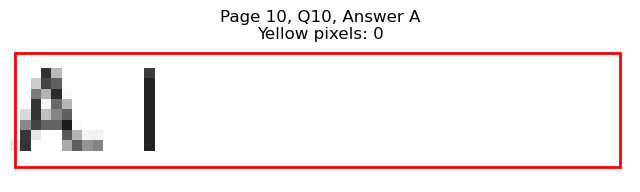

Page 10, Q10 - B: Detected box: x0=68.3, y0=242.6, x1=78.4, y1=253.6
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 32
Page 10, Q10, B: Yellow percentage: 0.0%


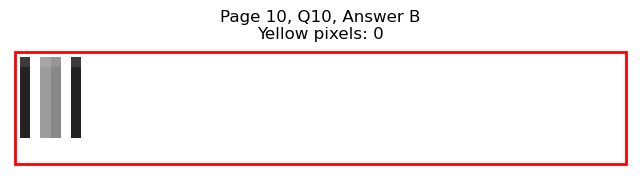

Page 10, Q10 - C: Detected box: x0=315.4, y0=734.8, x1=324.4, y1=745.9
Page 10, Q10, C: Yellow pixels: 671
Page 10, Q10, C: Total non-white pixels: 720
Page 10, Q10, C: Yellow percentage: 93.2%


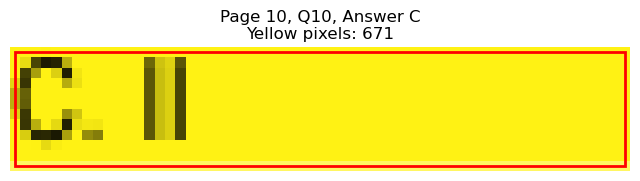

Page 10, Q10 - D: Detected box: x0=327.5, y0=242.6, x1=338.5, y1=253.6
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 43
Page 10, Q10, D: Yellow percentage: 0.0%


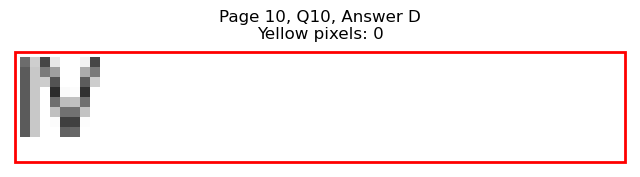


Page 10, Q10 - Selected Answer: C (based on yellow pixel count)





Page 11: Found 1 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=148.1, y1=114.8
Page 11, Q1, A: Yellow pixels: 1285
Page 11, Q1, A: Total non-white pixels: 1572
Page 11, Q1, A: Yellow percentage: 81.7%


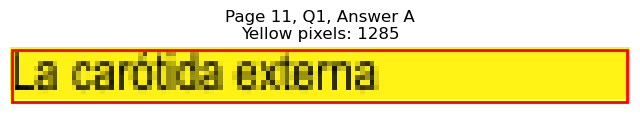

Page 11, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=145.6, y1=127.4
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 372
Page 11, Q1, B: Yellow percentage: 0.0%


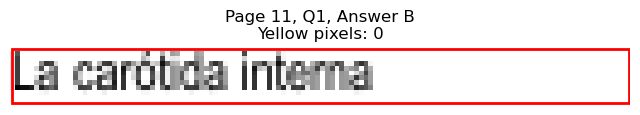

Page 11, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=396.7, y1=114.8
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 350
Page 11, Q1, C: Yellow percentage: 0.0%


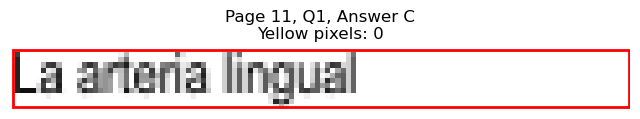

Page 11, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=427.3, y1=127.4
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 501
Page 11, Q1, D: Yellow percentage: 0.0%


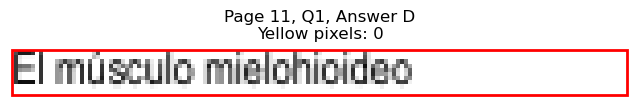


Page 11, Q1 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 31 años, politraumatizado, cursa con ...
1   ¿Cuál es la estructura u órgano que se hernia ...
2   Varón de 45 años, obeso y con diabetes mellitu...
3   Niño de 10 años, acude por dolor testicular de...
4   Varón de 40 años con hipoacusia y otorrea féti...
..                                                ...
95  La lesión traumática cerebral es una condición...
96  Varón de 55 años, consulta por dolor y calambr...
97  Paciente de 70 años con cáncer de esófago dist...
98  ¿Cuál es el tipo de colgajo muscular que tiene...
99  En cirugía de cuello, el triángulo limitado po...

[100 rows x 1 columns]

In [8]:
answers_df

option_A             option_B               option_C  \
0                   III                    I                     II   
1                  Bazo       Fondo gástrico                  Colon   
2      En asa izquierda       En asa derecha   En cañon de escopeta   
3          Epididimitis             Orquitis             Varicocele   
4          Colesteatoma       Otitis crónica           Otitis aguda   
..                  ...                  ...                    ...   
95    las convulsiones.            el dolor.  lesiones vertebrales.   
96          Aortoiliaca       Fémoropoplítea                Aórtica   
97                  >=7                2 a 3                  4 a 6   
98                    I                  III                     II   
99  La carótida externa  La carótida interna     La arteria lingual   

                        option_D  
0                              V  
1                        Epiplon  
2       Bocas separadas por piel  
3             Torsión testicular  
4               Glomus timpánico  
..                           ...  
95  isquemia e hipoxia cerebral.  
96                        Iliaca  
97                             1  
98                            IV  
99       El músculo mielohioideo  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions             option_A  \
0   Varón de 31 años, politraumatizado, cursa con ...                  III   
1   ¿Cuál es la estructura u órgano que se hernia ...                 Bazo   
2   Varón de 45 años, obeso y con diabetes mellitu...     En asa izquierda   
3   Niño de 10 años, acude por dolor testicular de...         Epididimitis   
4   Varón de 40 años con hipoacusia y otorrea féti...         Colesteatoma   
..                                                ...                  ...   
95  La lesión traumática cerebral es una condición...    las convulsiones.   
96  Varón de 55 años, consulta por dolor y calambr...          Aortoiliaca   
97  Paciente de 70 años con cáncer de esófago dist...                  >=7   
98  ¿Cuál es el tipo de colgajo muscular que tiene...                    I   
99  En cirugía de cuello, el triángulo limitado po...  La carótida externa   

               option_B               option_C                      option_D  \
0                     I                     II                             V   
1        Fondo gástrico                  Colon                       Epiplon   
2        En asa derecha   En cañon de escopeta      Bocas separadas por piel   
3              Orquitis             Varicocele            Torsión testicular   
4        Otitis crónica           Otitis aguda              Glomus timpánico   
..                  ...                    ...                           ...   
95            el dolor.  lesiones vertebrales.  isquemia e hipoxia cerebral.   
96       Fémoropoplítea                Aórtica                        Iliaca   
97                2 a 3                  4 a 6                             1   
98                  III                     II                            IV   
99  La carótida interna     La arteria lingual       El músculo mielohioideo   

   correct_answer  
0               A  
1               B  
2               A  
3               D  
4               A  
..            ...  
95              D  
96              B  
97              A  
98              C  
99              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/CIRUGIA GENERAL.csv
